# Advanced Statistics for Physics Analysis - Final Project
Students:
* Conforto Filippo - 2021856
* Domenichetti Lorenzo - 2011653
* Faorlin Tommaso - 2021857 

##### 24/06/2021

<img src="sbi.png" width="400" height="500" >
<br></br>
Analyse the data coming from the **service call-center** of a multinational private company, UNOX, that produces professional ovens. The main goal of this project is to retrieve useful information out of these data, using advanced statistics methods, such as Markov Chain Monte Carlo or Bayesian Networks. 

In [1]:
#import libraries
defaultW <- getOption("warn")
options(warn = -1)

suppressMessages(library(readxl))
suppressMessages(library(bnlearn))
suppressMessages(library(tidyverse))
suppressMessages(library(mcmcplots))
suppressMessages(library(lubridate))
suppressMessages(library(rjags))
suppressMessages(library(corrplot))
suppressMessages(library(latex2exp))
#suppressMessages(library(Rgraphviz))
options(repr.plot.width=15, repr.plot.height=10)


#Reading data and show column names and types and first row.
df <- read_csv("data_clean.csv", col_types = cols())

#Convert contact duration from string to difftime.
df[['Contact Duration']] = unlist(as.difftime(df[['Contact Duration']]))

options(warn = defaultW)

In [2]:
head(df, 3)

Channel,Initiation Timestamp,System Phone Number,Queue,Disconnect Timestamp,Contact Duration,Connected to agent timestamp,Agent interaction duration,Agent connection attempts,Disconnect Reason,Customer Phone Number-first4,Customer Phone number hashed,Agent hashed,Customer_Country_Code
<chr>,<dttm>,<chr>,<chr>,<dttm>,<time>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
Chat,2021-05-22 21:23:24,NA,NA,2021-05-22 21:23:35,00:00:11,NA,NA,0,NA,NA,NA,NA,ZZ
Voice,2021-05-22 16:18:30,+390497360746,NA,2021-05-22 16:18:44,00:00:13,NA,NA,0,Contact flow disconnect,+3933,5442d3d57332fc7c26fae2b000a0349339cec6e2e467c763521f5fe8f10e8e37,NA,IT
Voice,2021-05-22 16:16:45,+390497360746,NA,2021-05-22 16:17:01,00:00:15,NA,NA,0,Contact flow disconnect,+3904,5bc6a1d7e01f0dee9a95d6f7c859bd0412175631f3c21de724dd69742b1e741f,NA,IT


Outline of today's presentation:

* Descriptive statistics and Bayesian inference on time and call duration (with focus on outside-working-hours calls);
* Predict how many calls tomorrow, studying the calls-per-day;
* Bayesian network;
* See discrepancies COVID - not COVID (July 2019 and March 2021);
* A more complex sampling on the call distribution for outside-working-hours calls;
* Conclusions. 

## 1. Descriptive statistics on time and call duration

### A. Call Duration

* We will focus on **voice calls**;

* The time between two consecutive events follows exactly an exponential distribution $Exp(\lambda)$: We make inference on the $\lambda$ parameter;

An exponential distribution able to fit the data correctly would be one with a mean between a **minute and a half and seven/eight minutes**. The exponential rate $\lambda$ is then the inverse, measured in seconds, of such values. 
* We choose a **uniform prior** in this interval and the final posterior, given the large amount of data (115701 'clean' calls), will be almost independent on this choice.

In [3]:
#consider only voice calls. The 'Chat' alternative deserves a separate treatment.
df_v = subset(df, df$Channel == 'Voice')

#and also select only entries with non NA interaction duration - i.e. answered calls.
df_v = df_v[!is.na(df_v[['Agent interaction duration']]), ]

vec_duration = df_v[['Agent interaction duration']]
#consider only calls that last less than 2000 sec - higher values are negligible. 
vec_duration = vec_duration[vec_duration<2000]

#considering the time interval of the previous assumption
p <- seq(1/480, 1/90, length = 3000)

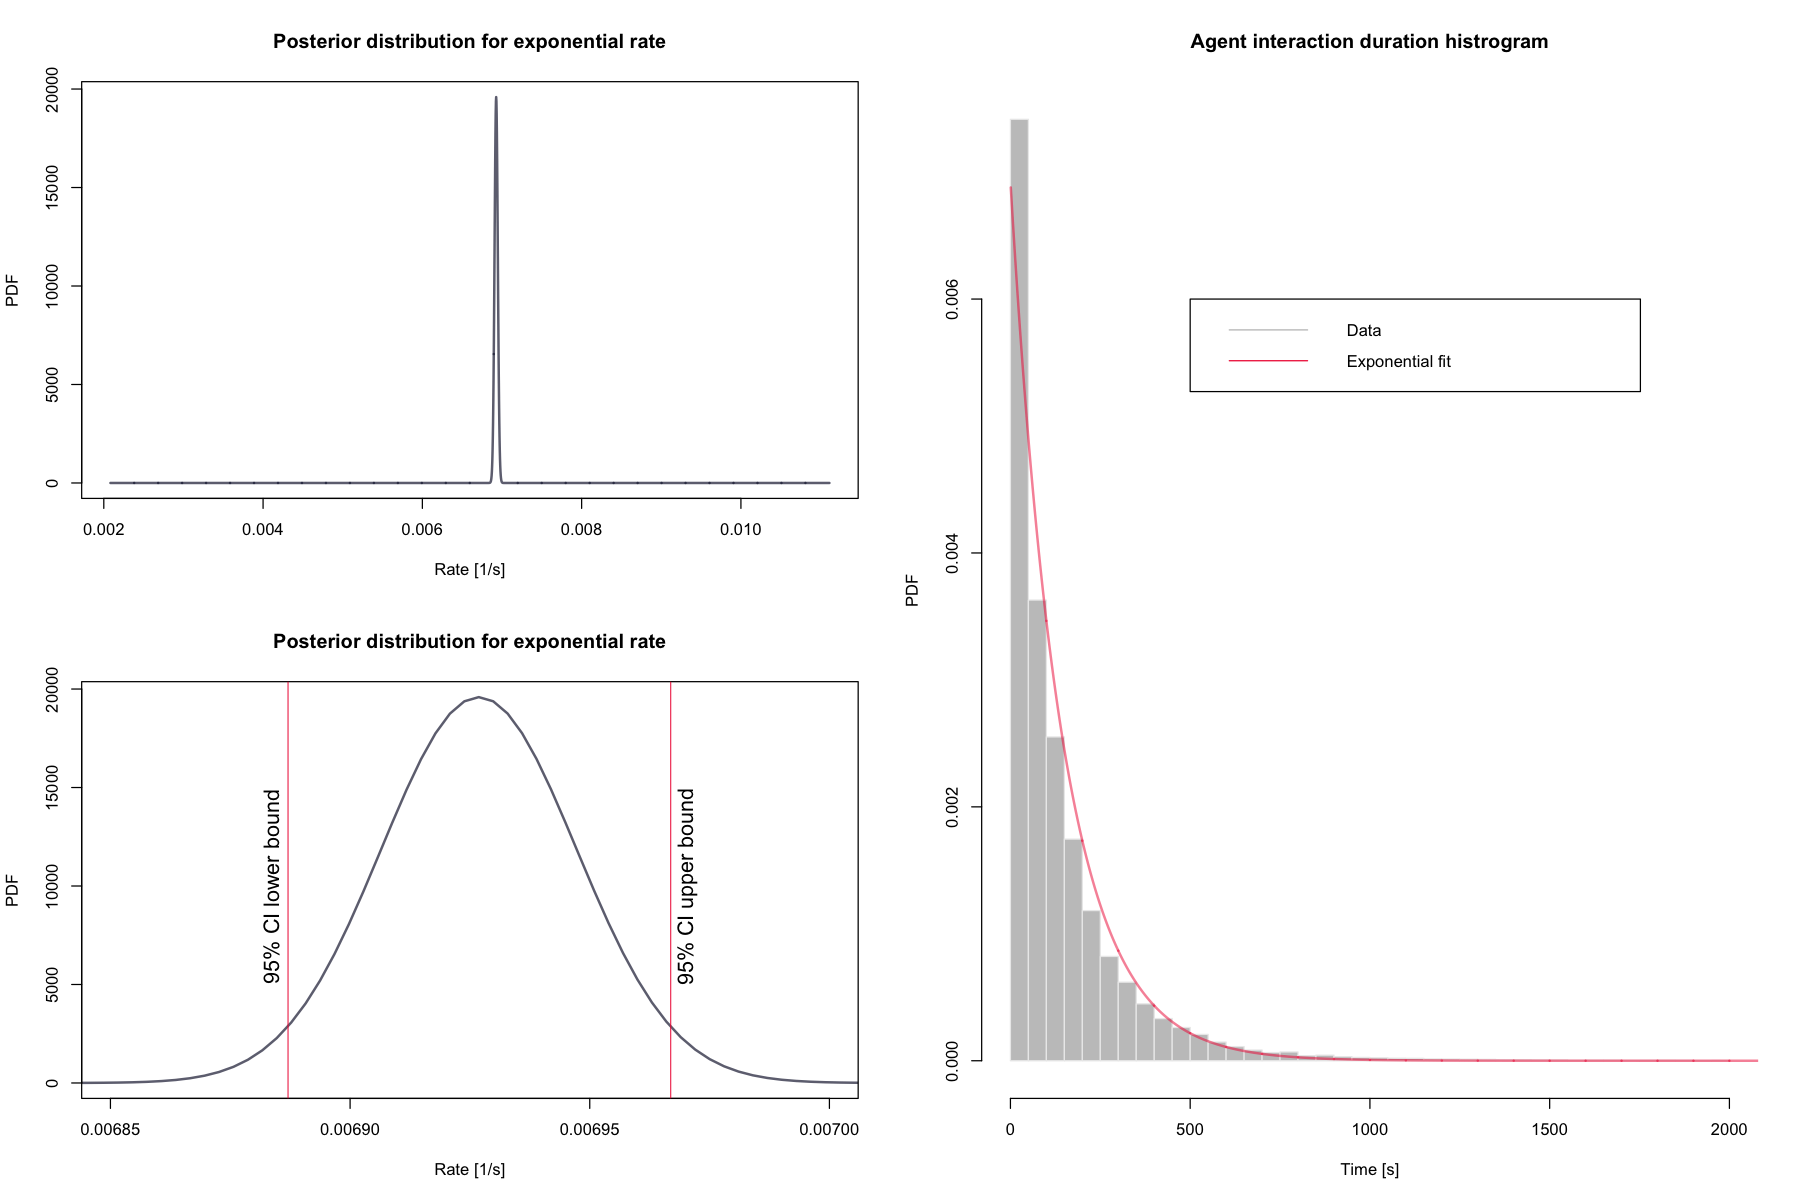

In [4]:
layout(matrix(c(1,2,3,3), nrow =2))

len_d = length(vec_duration)
sum_d = sum(vec_duration)

#Uniform Prior: expected mean between 100 (1.3') and 420 (7') seconds.
plot(p, dgamma(p, 1+len_d, 1+sum_d),
     main = 'Posterior distribution for exponential rate',
     xlab = 'Rate [1/s]', ylab = 'PDF', t = 'l', lwd = 2,
     col = rgb(0.12,0.13,0.25, alpha = 0.7))

plot(p, dgamma(p, 1+len_d, 1+sum_d),
     main = 'Posterior distribution for exponential rate',
     xlab = 'Rate [1/s]', ylab = 'PDF', t = 'l', lwd = 2,
     col = rgb(0.12,0.13,0.25, alpha = 0.7),
     xlim = c(0.00685,0.0070))

#calculation of 95% CI for the posterior distribution.
minq = qgamma(0.025, 1+len_d, 1+sum_d)
maxq = qgamma(0.975, 1+len_d, 1+sum_d)


abline(v = minq,col = rgb(0.94,0.14,0.24,alpha=0.8))
text(minq-minq/2000,10000, "95% CI lower bound", cex =1.3, srt= 90)

abline(v = maxq, col = rgb(0.94,0.14,0.24,alpha=0.8))
text(maxq+maxq/2000,10000, "95% CI upper bound", cex =1.3, srt= 90)


hist(vec_duration, nc = 30, main = 'Agent interaction duration histrogram',
     xlab = 'Time [s]', ylab = 'PDF', freq = FALSE,
     col = rgb(0.75,0.75,0.75,alpha=0.9),
     border = rgb(0.92,0.92,0.92,alpha=1))

lines(1:3000, dexp(1:3000, p[which.max(dgamma(p, 1+len_d, 1+ sum_d))]),
      lwd = 2,
      col = rgb(0.94,0.14,0.24, alpha = 0.5))
legend(500, 0.006, legend=c("Data", "Exponential fit"),
       col=c(rgb(0.75,0.75,0.75), rgb(0.94,0.14,0.24)), lty=1:1)

a = 1+len_d
s = 1/(1+sum_d)
meanp = a*s
varp = a*s^2

In [5]:
message("The mean of the rate posterior distribution is: ", round(meanp, 5), 
        " with variance: ", round(varp, 13))
message("It corresponds to a value of ", round(1/meanp,2),
        " seconds as average interaction time.")
message("The 95% CI corresponds to mean times in the [",round(1/maxq, 1),
        ", " , round(1/minq, 1), "] interval.")

The mean of the rate posterior distribution is: 0.00693 with variance: 4.147e-10

It corresponds to a value of 144.36 seconds as average interaction time.

The 95% CI corresponds to mean times in the [143.5, 145.2] interval.



### B. Not-answered calls (and calls out of working hours)

* In the dataset they are the one with 'NA' as *Agent interaction duration*;
* The resulting distribution is **bimodal**, and it looks very similar to the distribution of regular calls that we will discuss later on;
* Calls coming from **Italian customers**.

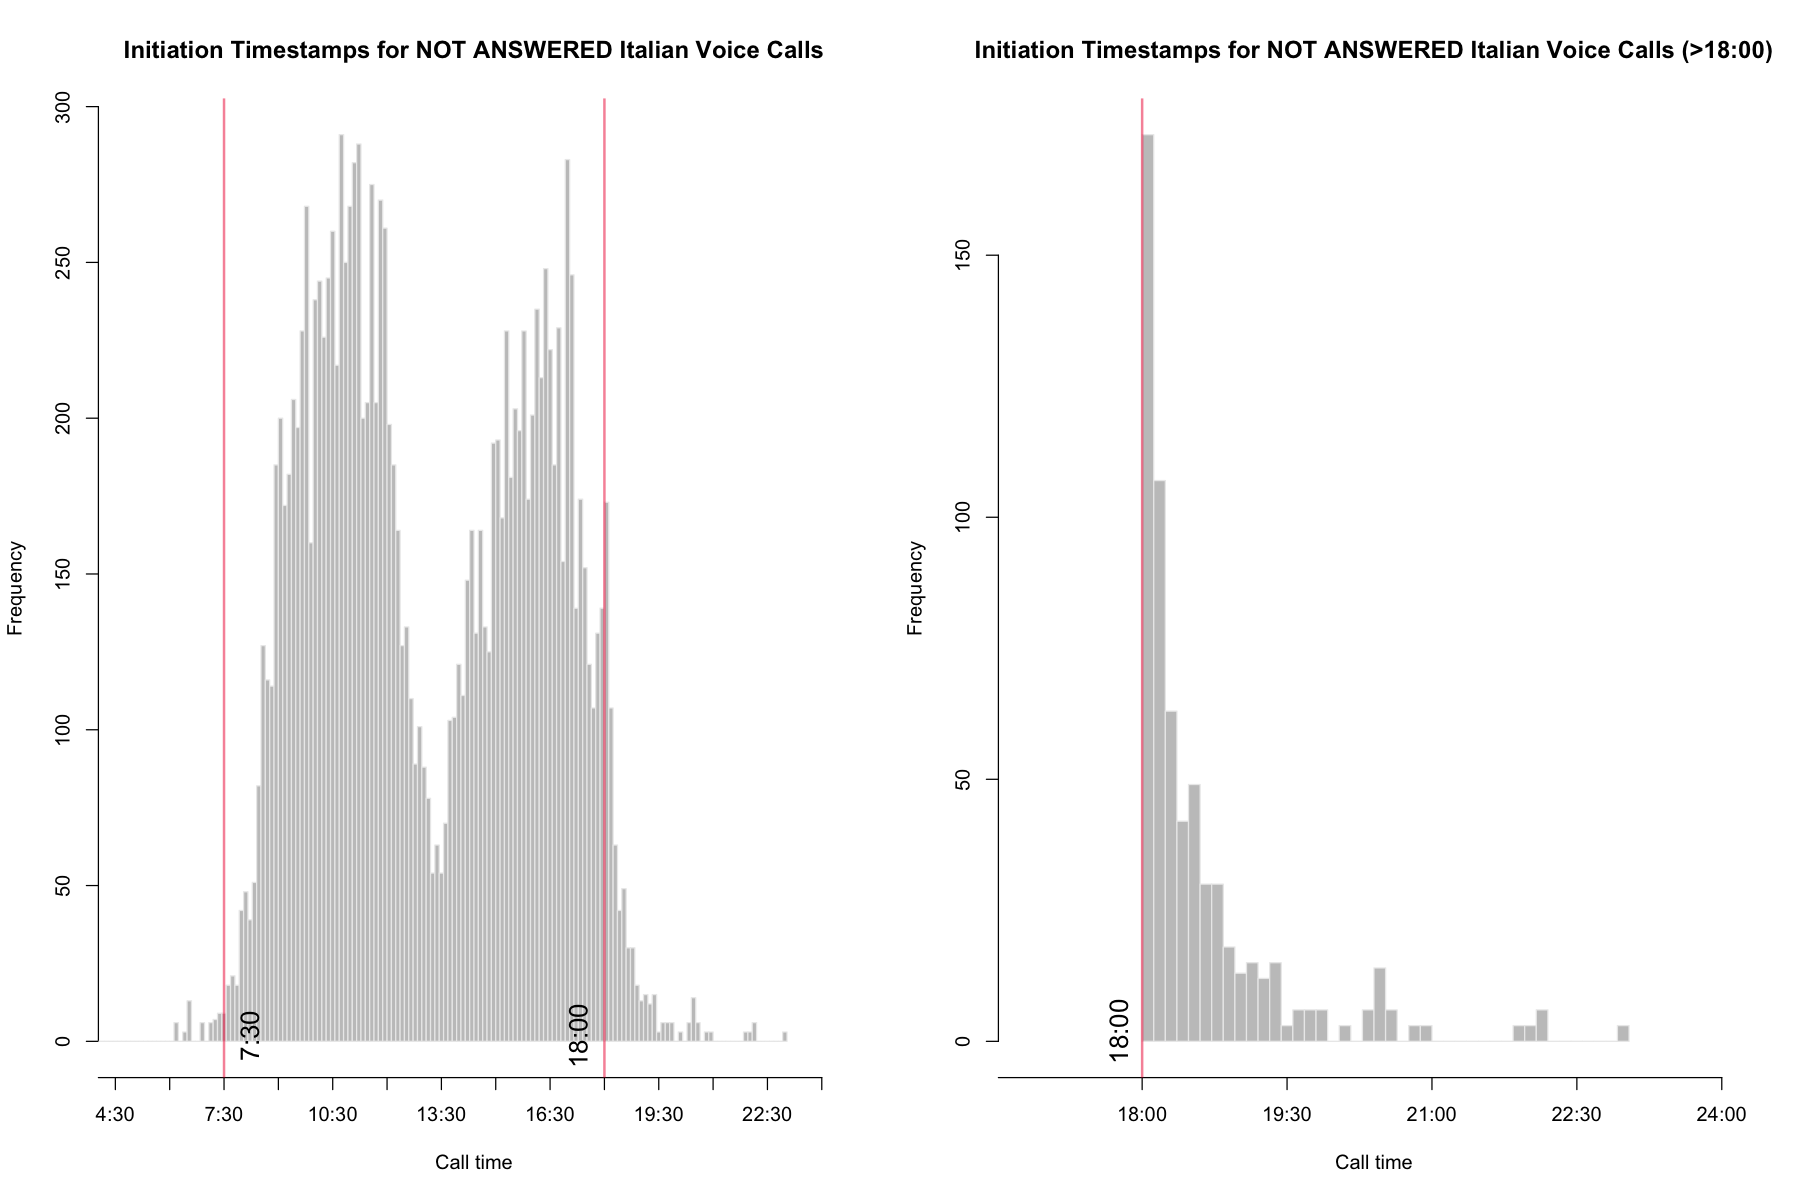

In [6]:
#consider only voice calls. The 'Chat' alternative deserves a separate treatment.
df_noris = subset(df, df$Channel == 'Voice')

#and also select only entries with non NA interaction duration - i.e. answered calls.
df_noris = df_noris[is.na(df_noris[['Agent interaction duration']]), ]

#Select only Italy
df_noris = subset(df_noris, df_noris$Customer_Country_Code=='IT')

#hashing data and rescaling into the [0,1] interval.
v_Minutes_Hashed_IT_NA = hour(ymd_hms(df_noris[['Initiation Timestamp']]))*60 +
                            minute( ymd_hms(df_noris[['Initiation Timestamp']]))
v_Minutes_Hashed_IT_NA = v_Minutes_Hashed_IT_NA/(24*60)
df_noris['MinHashed'] = v_Minutes_Hashed_IT_NA

par(mfrow = c(1,2))

hist(v_Minutes_Hashed_IT_NA, nc = 170,
     main = 'Initiation Timestamps for NOT ANSWERED Italian Voice Calls',
     xlab = 'Call time', 
     ylab = 'Frequency',
     col = rgb(0.75,0.75,0.75,alpha=0.9),
     border = rgb(0.92,0.92,0.92,alpha=1),
     freq = TRUE,
     xlim = c(0.2,1),
     xaxt='n')

axis(side=1, at=seq(0,1,1/16),
     labels=paste0(trunc(seq(0,24,1.5)),c(rep(c(":00",":30"),8),":00")))

abline(v = 7.5/24, col = rgb(0.94,0.14,0.24,alpha=0.5), lwd = 2)
text(7.5/24+0.03,2, "7:30", cex =1.3, srt= 90)

abline(v = 18/(24), col = rgb(0.94,0.14,0.24,alpha=0.5), lwd = 2)
text(18/(24)-0.03,2,"18:00", cex =1.3, srt= 90)

df_noris_NWH = subset(df_noris, df_noris$MinHashed > 18/24)

hist(df_noris_NWH$MinHashed, nc = 50,
     main = 'Initiation Timestamps for NOT ANSWERED Italian Voice Calls (>18:00)',
     xlab = 'Call time', 
     ylab = 'Frequency', col = rgb(0.75,0.75,0.75,alpha=0.9),
     border = rgb(0.92,0.92,0.92,alpha=1),
     freq = TRUE,
     xlim = c(0.7, 1),
     xaxt='n')

axis(side=1, at=seq(0,1,1/16), labels=paste0(trunc(seq(0,24,1.5)),
                                             c(rep(c(":00",":30"),8),":00")))

abline(v = 18/(24), col = rgb(0.94,0.14,0.24,alpha=0.5), lwd = 2)
text(18/(24)-0.01,2,"18:00", cex =1.3, srt= 90)

This is the JAGS model to perform the MCMC on the exponential distribution of calls out of the working hours. We use a uniform prior for $\lambda$.

In [7]:
y = df_noris_NWH$MinHashed - 
    rep(18/24, length(df_noris_NWH$MinHashed))
N = length(y)

dataList = list(
    y = y[y<0.85] ,
    N = N 
)

#upload the model
jm_dexp <- jags.model('jags_calloutwork.txt', dataList)

#burn-in phase
update(jm_dexp, 1000)

chain_dexp <- coda.samples(jm_dexp, c("rate"), n.iter=10000)

mean_exp = summary(chain_dexp)$statistics[[1]]

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 638
   Unobserved stochastic nodes: 1
   Total graph size: 641

Initializing model



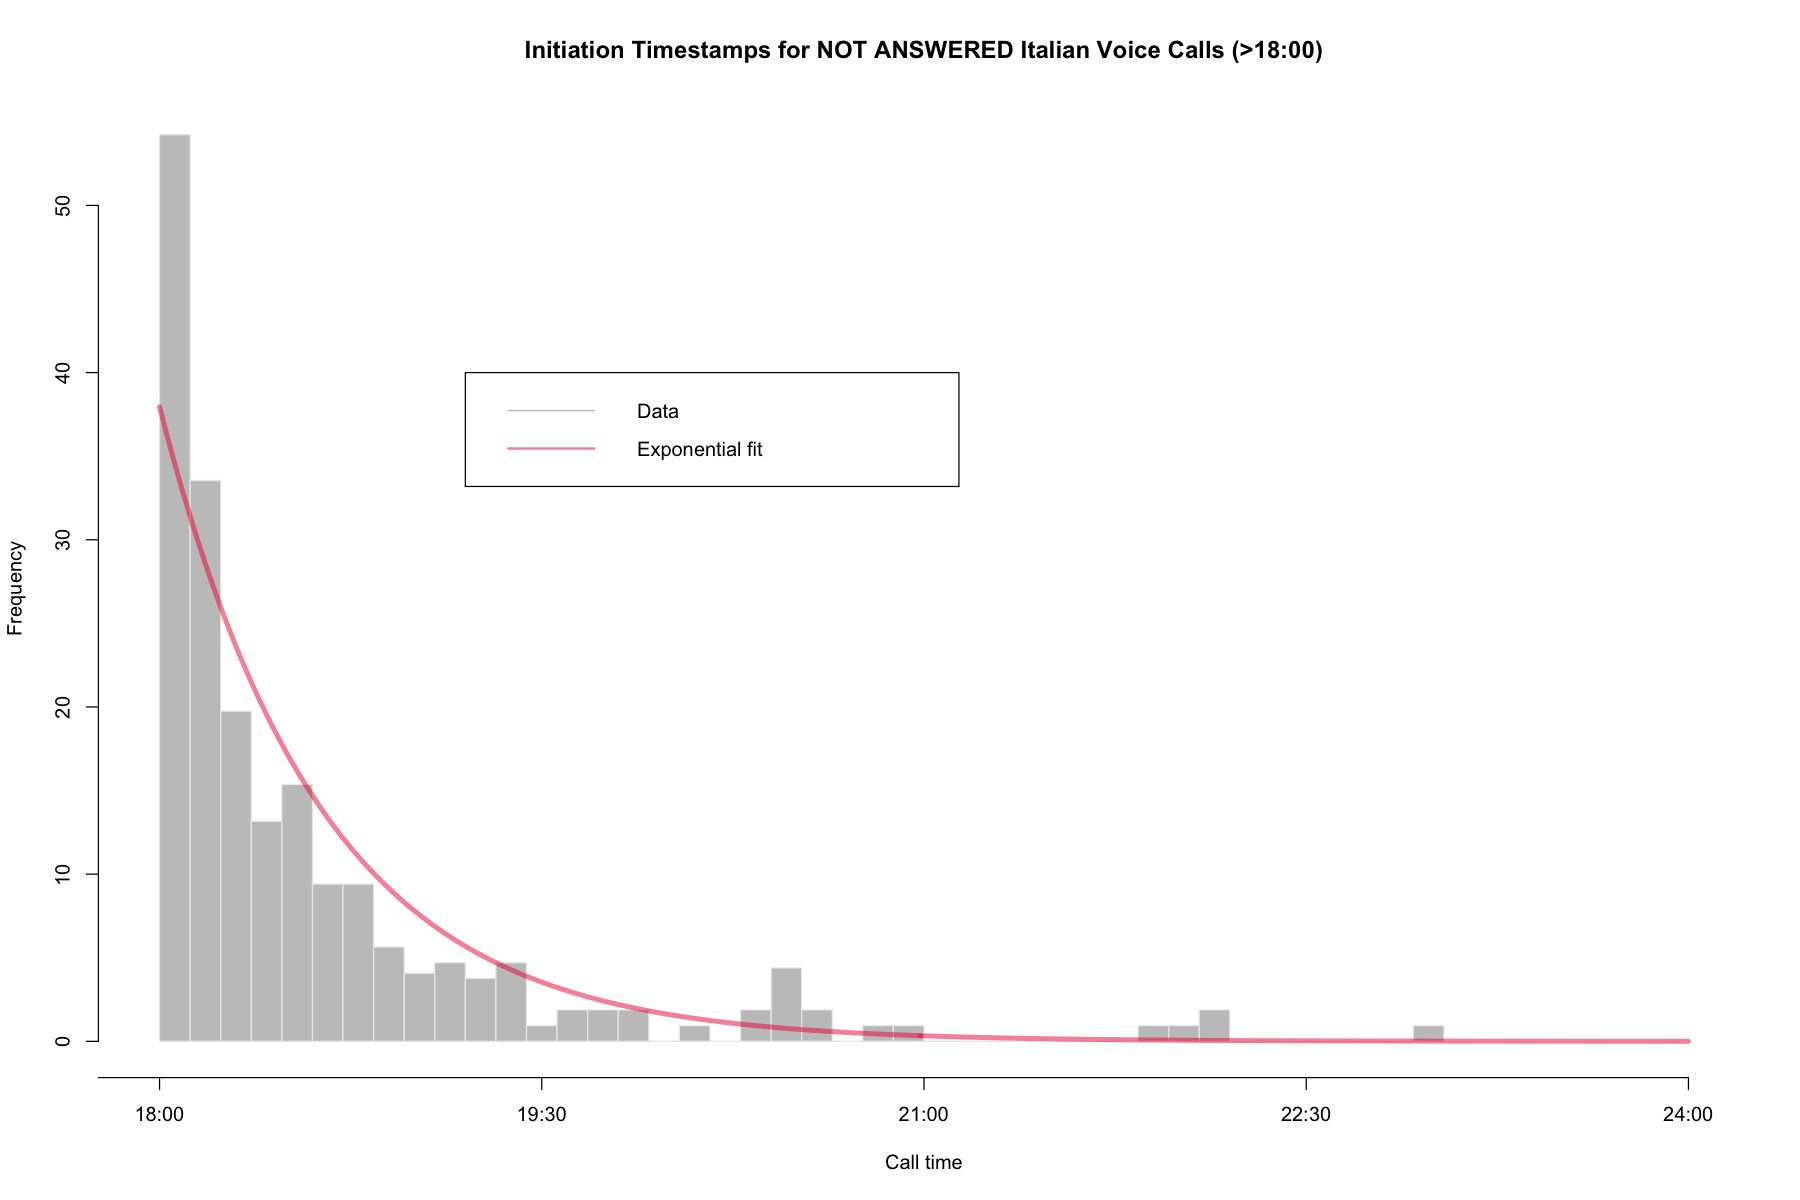

In [8]:
hist(y+18/24, nc = 50, main = 'Initiation Timestamps for NOT ANSWERED Italian Voice Calls (>18:00)',
     xlab = 'Call time', 
     ylab = 'Frequency',
     col = rgb(0.75,0.75,0.75,alpha=0.9),
     border = rgb(0.92,0.92,0.92,alpha=1),
     freq = FALSE, xlim = c(0.75, 1), xaxt='n')
legend(0.8, 40, legend=c("Data", "Exponential fit"),
       col=c(rgb(0.75,0.75,0.75), rgb(0.94,0.14,0.24,alpha=0.5)),
       lty=1:1, lwd=1:4)

axis(side=1, at=seq(0,1,1/16),
     labels=paste0(trunc(seq(0,24,1.5)),
                   c(rep(c(":00",":30"),8),":00")))

xax = seq(0.75, 1, length = 200)
lines(xax, dexp(xax-0.75, mean_exp),
      col=rgb(0.94,0.14,0.24,alpha=0.5), lwd = 4)

In [9]:
message("The mean of the rate posterior distribution is: ",
        round(mean_exp,0), 
        " with standard deviation: ", round(summary(chain_dexp)$statistics[[2]], 0))
message("On average, outside working hours calls arrive at around ",
        round(24/mean_exp,2), ' with a standard deviation of ', round(24*sqrt(summary(chain_dexp)$statistics[[2]])/mean_exp^2,2),
        " hours after 18:00")

The mean of the rate posterior distribution is: 38 with standard deviation: 2

On average, outside working hours calls arrive at around 0.63 with a standard deviation of 0.02 hours after 18:00



### Chain inspection

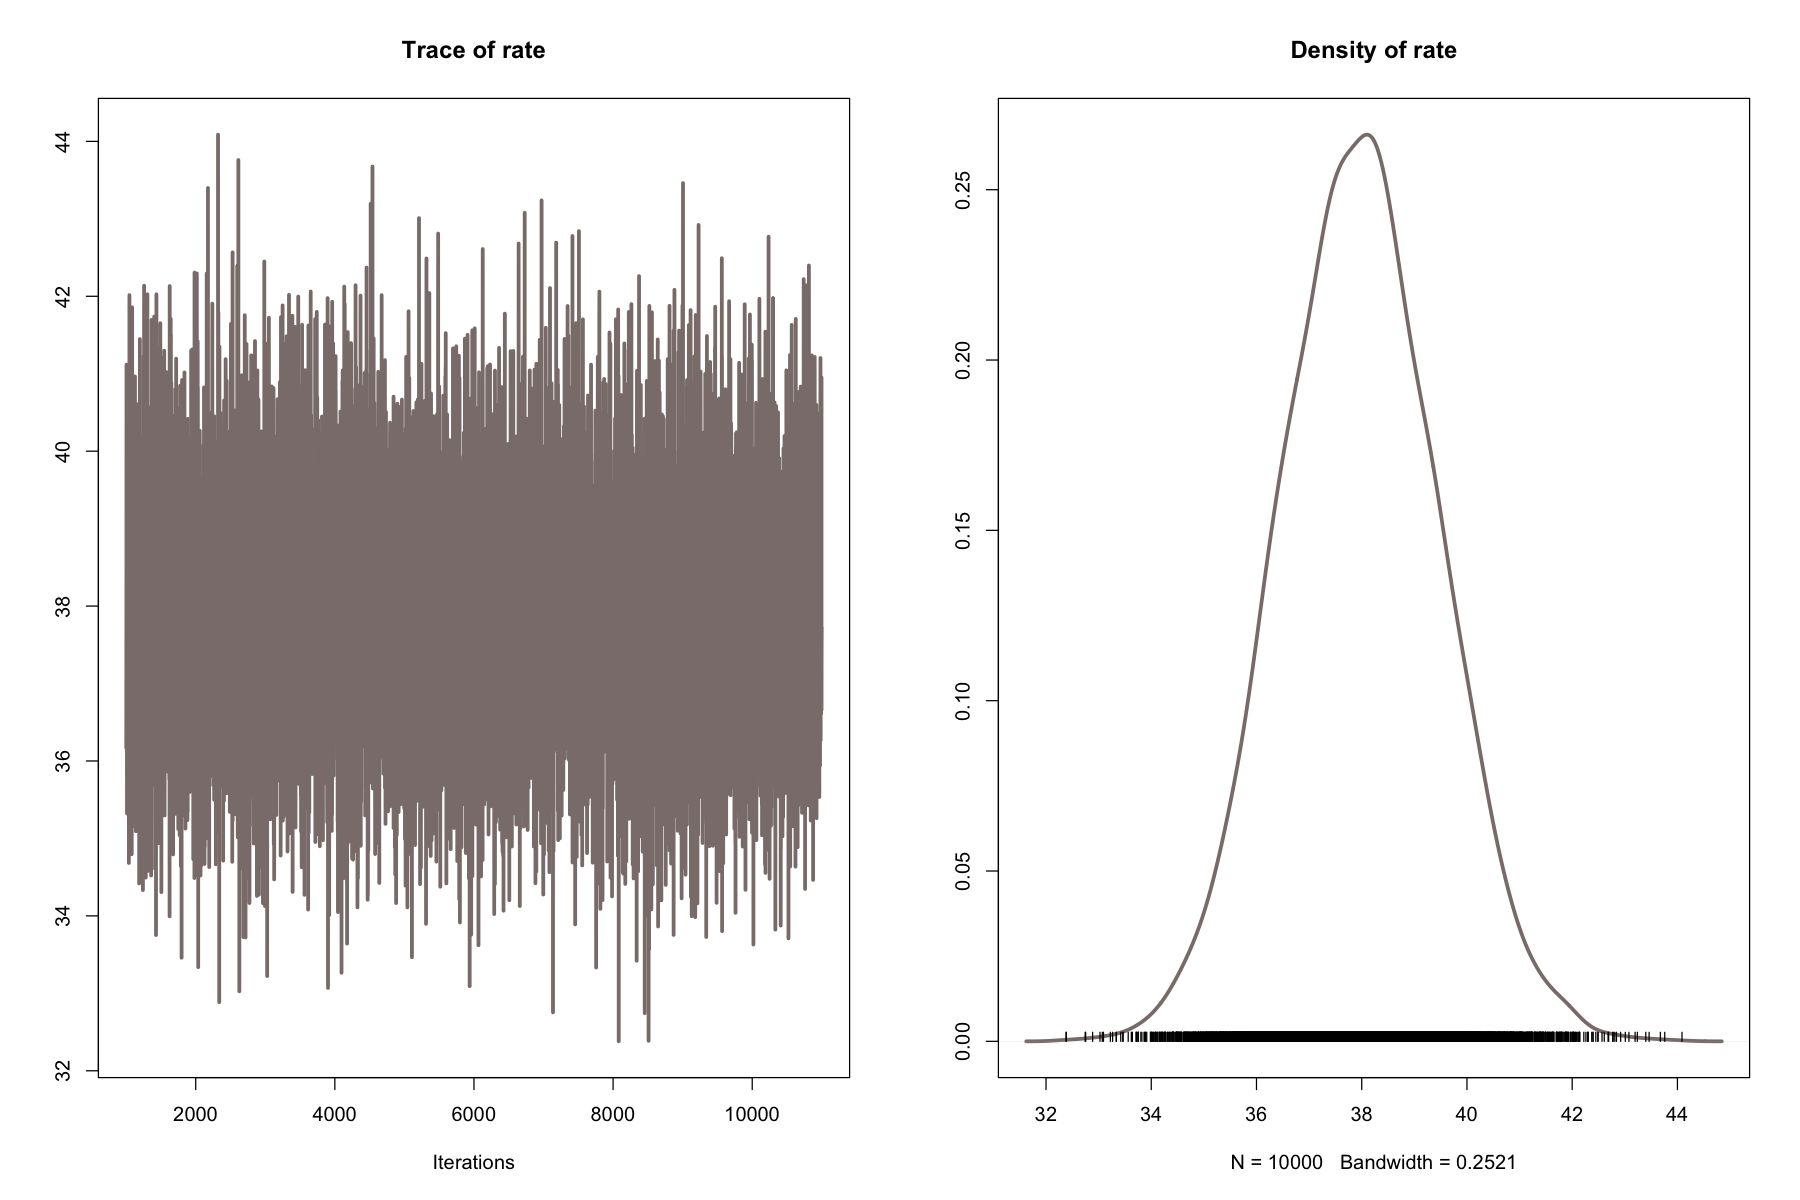

In [10]:
plot(chain_dexp, col='mistyrose4', lwd=3)

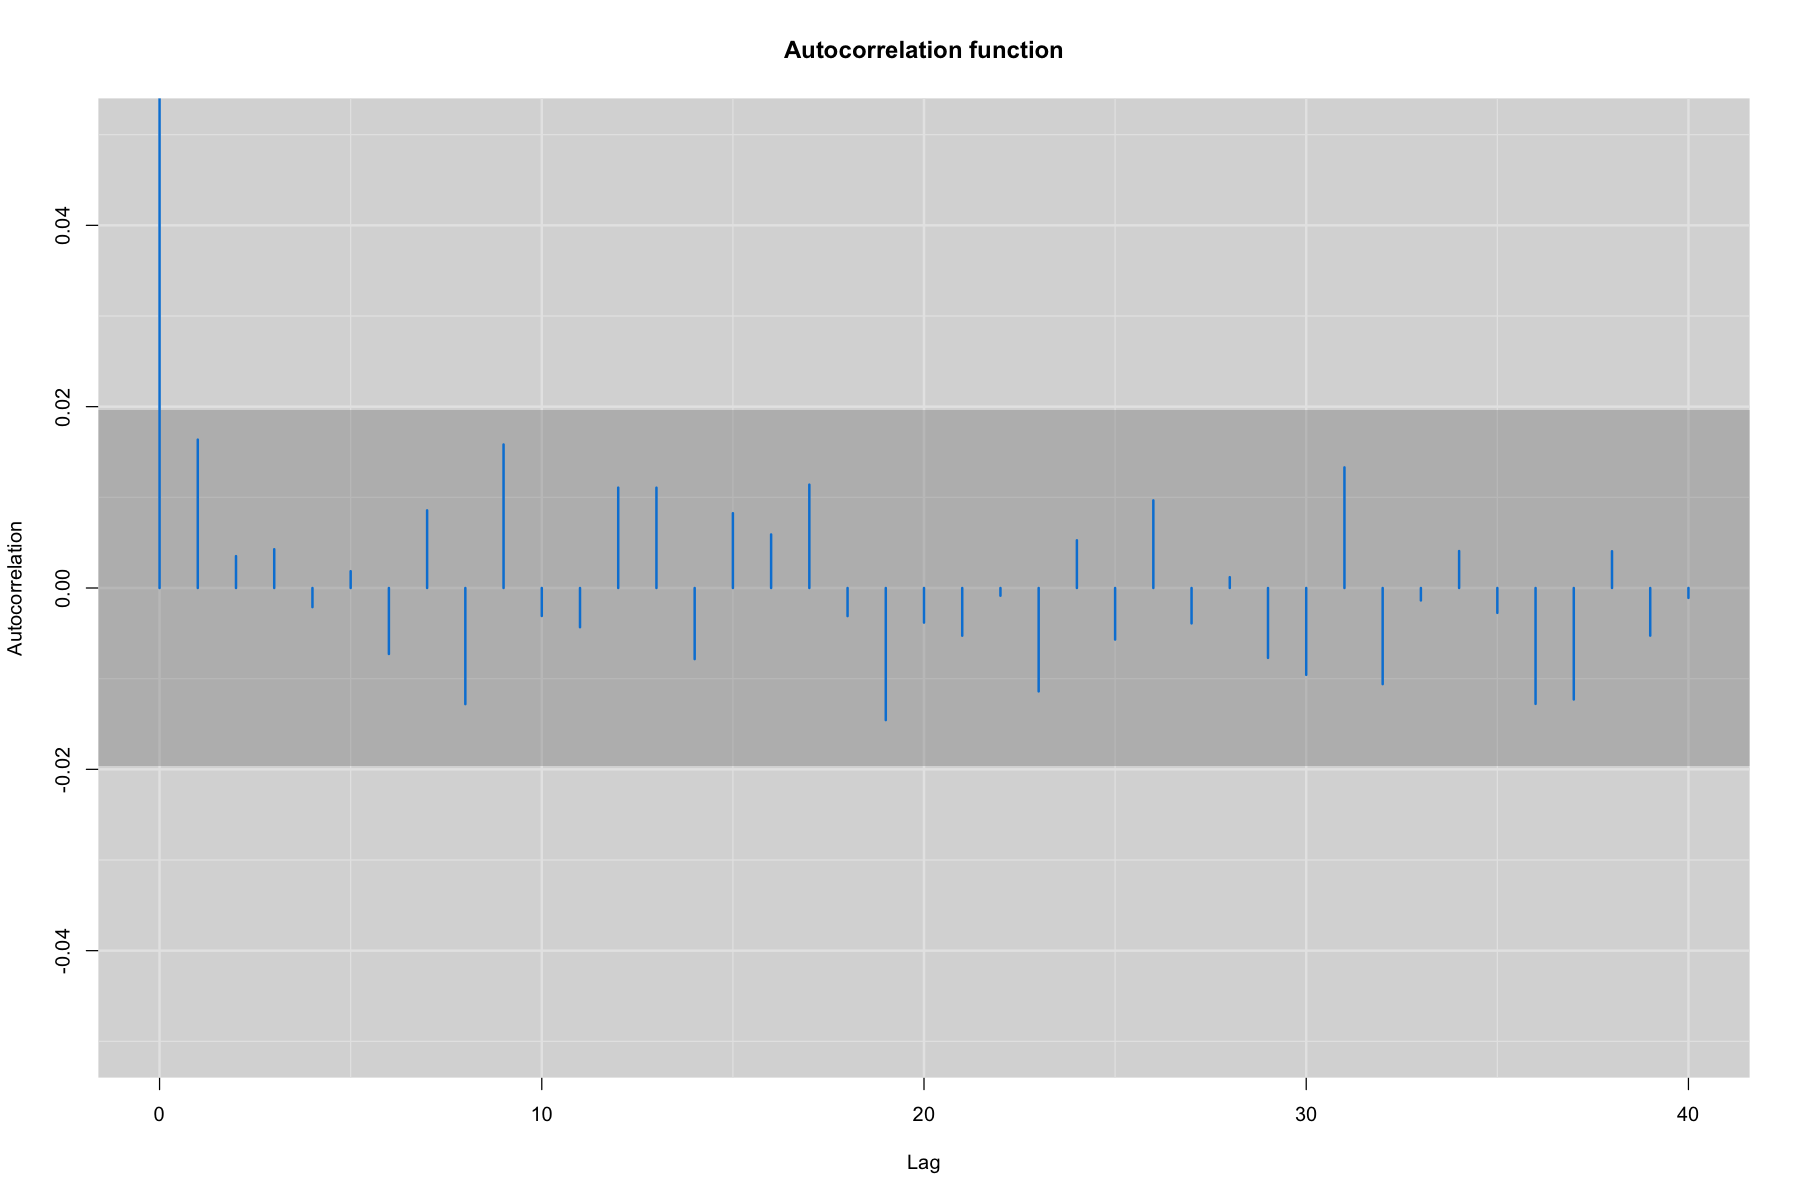

In [11]:
autplot1(chain_dexp,  ylim=c(-0.05,0.05), style='gray', main='Autocorrelation function')

### C. Calls per day


* Inference on the effective number of calls carried out;
* Data from **2021** without **saturdays** and **sundays**;
* Given the high number of calls, the distribution chosen is a **normal** one. 

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 98
   Unobserved stochastic nodes: 2
   Total graph size: 102

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 98
   Unobserved stochastic nodes: 2
   Total graph size: 102

Initializing model



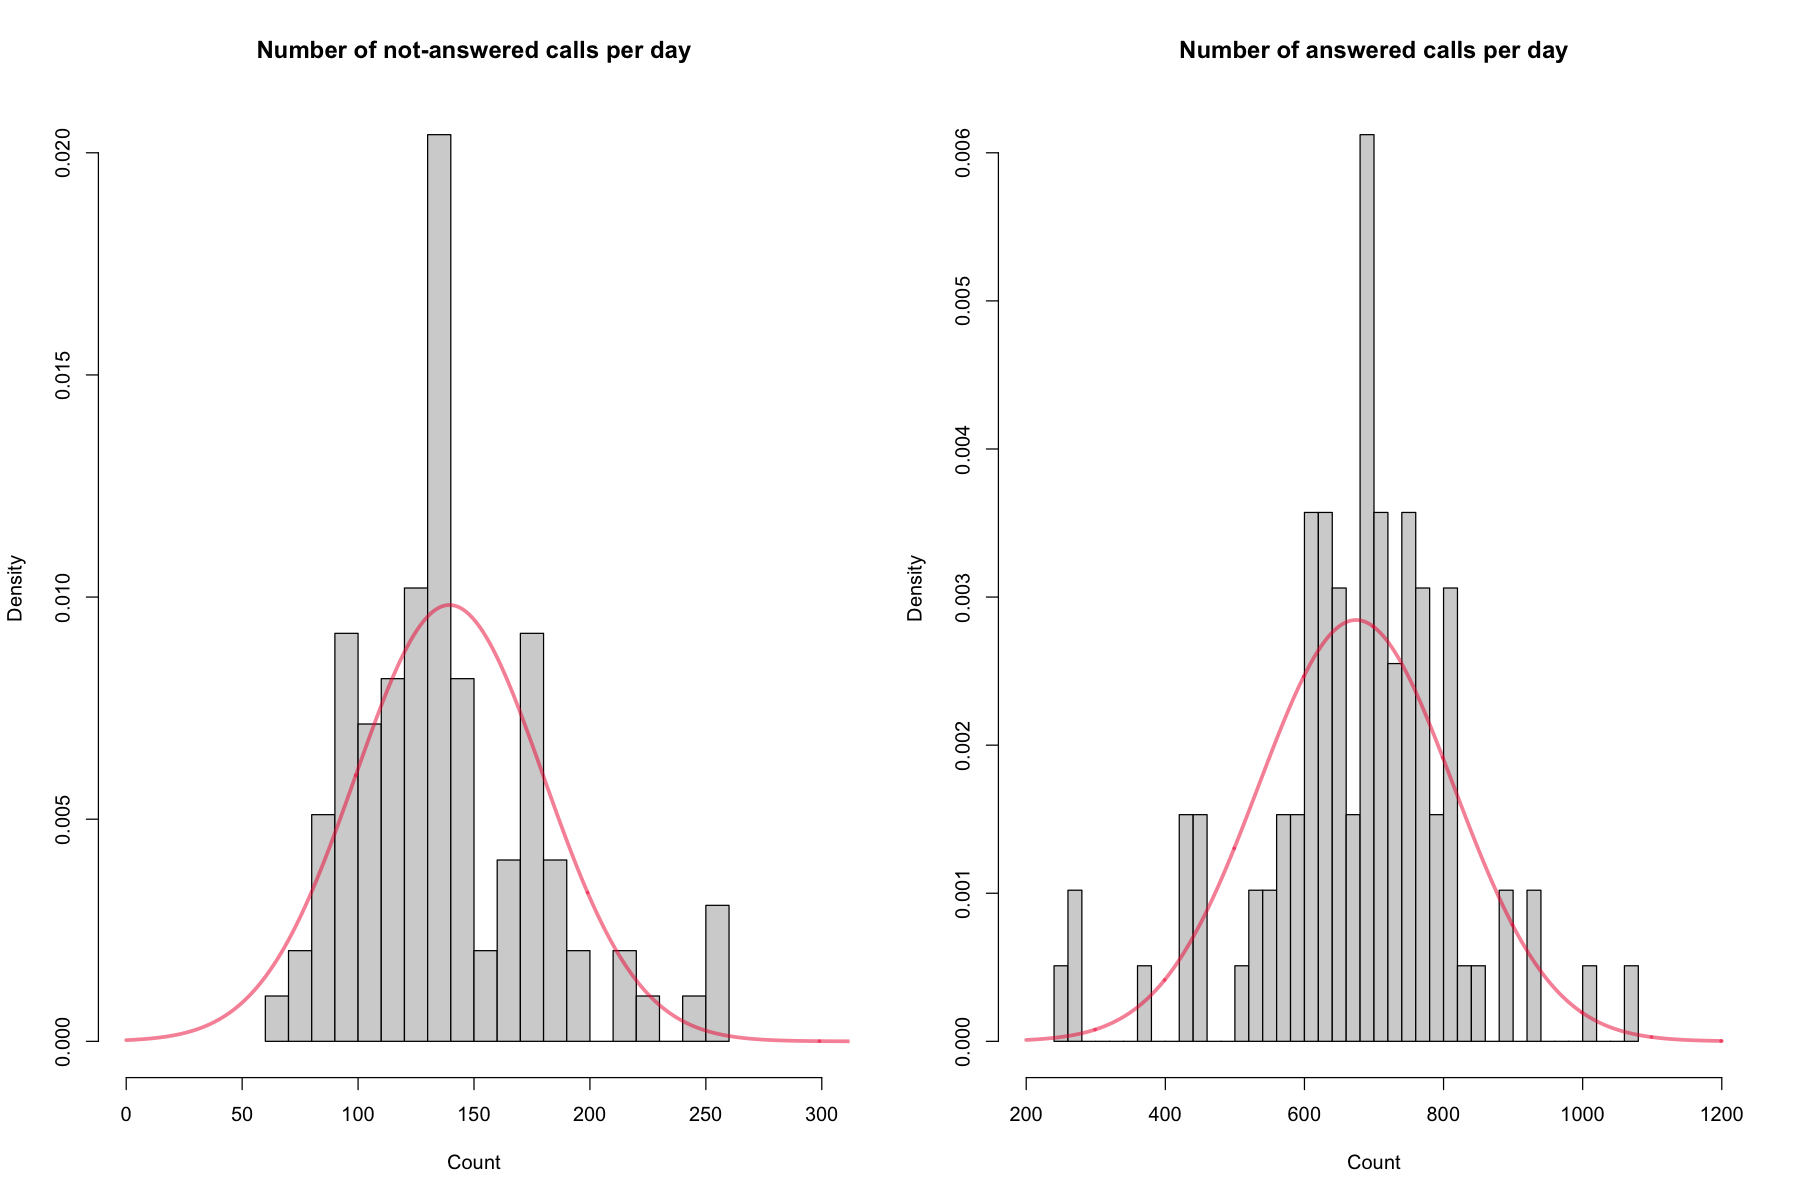

In [12]:
df_v_it = subset(df_v, df_v[['Agent interaction duration']]<2000)

df_v_it = subset(df_v_it, df_v_it$Customer_Country_Code=='IT')

#removing the calls received in 2019
df_v_it = subset(df_v_it,
                 df_v_it[["Initiation Timestamp"]]>ymd("2021-01-03"))
df_noris = subset(df_noris,
                  df_noris[["Initiation Timestamp"]]>ymd("2021-01-03"))


#convert timestamp to date.
vec_date = as_date(ymd_hms((df_noris[['Initiation Timestamp']])))
vec_date_ris = as_date(ymd_hms((df_v_it[['Initiation Timestamp']])))

#removing not-working days and count entries with the table() function. 
wdays = vec_date[ weekdays(vec_date) != 'Sabato']
wdays = wdays[weekdays(wdays) != 'Domenica']
vec_res = table(wdays)

wdays_ris = vec_date_ris[ weekdays(vec_date_ris) != 'Sabato']
wdays_ris = wdays_ris[weekdays(wdays_ris) != 'Domenica']
vec_res_ris = table(wdays_ris)


dataList = list(
    y = unclass(vec_res),
    N = length(vec_res) 
)

dataList_ris = list(
    y = unclass(vec_res_ris),
    N = length(vec_res_ris) 
)

#simple normal model to sample our data. 
jm_dnorm <- jags.model('jags_normal.txt' , dataList)
update(jm_dnorm , 1000)
chain_dnorm <- coda.samples(jm_dnorm , c("rate", "tau"),
                            n.iter=50000)

mean_dnorm = summary(chain_dnorm)$statistics

jm_dnorm_ris <- jags.model('jags_normal.txt' , dataList_ris)
update(jm_dnorm_ris , 1000)
chain_dnorm_ris <- coda.samples(jm_dnorm_ris , c("rate", "tau"),
                                n.iter=50000)

mean_dnorm_ris = summary(chain_dnorm_ris)$statistics

par(mfrow = c(1,2))
hist(vec_res,
     nc = 20,
     xlim = c(0,300),
     main = "Number of not-answered calls per day",
     xlab = 'Count',
     ylab = 'Density',
     freq = FALSE)
lines(0:400, dnorm(0:400, mean_dnorm[1], 1/sqrt(mean_dnorm[2]) ),
      lwd = 3,
      col = rgb(0.94,0.14,0.24,alpha=0.5))

hist(vec_res_ris,
     nc = 30,
     xlim = c(200,1200),
     main = "Number of answered calls per day",
     xlab = 'Count',
     ylab = 'Density',
     freq = FALSE)
lines(200:1200, dnorm(200:1200, mean_dnorm_ris[1], 1/sqrt(mean_dnorm_ris[2]) ),
      lwd = 3, col = rgb(0.94,0.14,0.24,alpha=0.5))

The distributions have clearly a gaussian shape and we used JAGS to evaluate the correct posteriors both for not answered and answered calls. As best estimates, we select the mean of the posterior distributions.

Analysing also data from 2020 and the whole 2019 would surely lead to major advantages in terms of the sampled distribution, but it would surely lead also to a wrong estimation of the calls per day, because the company had a strong growth in the past two years. 

Fortunately, it is possible to notice that answered calls are much more than not answered ones.


In [13]:
message('Markov chain on the non-answered call distribution')
message("The mean for the mean parameter is: ",
        round(mean_dnorm[1], 0),
        " with standard deviation: ", round(mean_dnorm[1,2], 0))
message("The mean for the standard deviation is: ", 
        round(1/sqrt(mean_dnorm[2]), 0), 
        " with standard deviation: ", round(mean_dnorm[2,2]/
                                  (2*(mean_dnorm[2,1])^(1.5)), 0))

Markov chain on the non-answered call distribution

The mean for the mean parameter is: 139 with standard deviation: 4

The mean for the standard deviation is: 41 with standard deviation: 3



In [14]:
message('Markov chain on the answered call distribution')
message("The mean for the mean parameter is: ",
        round(mean_dnorm_ris[1], 0),
        " with standard deviation: ", round(mean_dnorm_ris[1,2], 0))
message("The mean for the standard deviation is: ",
        round(1/sqrt(mean_dnorm_ris[2]), 0),
        " with standard deviationvariance: ", round(mean_dnorm_ris[2,2]
                                  /(2*(mean_dnorm_ris[2,1])^(1.5)), 0))

Markov chain on the answered call distribution

The mean for the mean parameter is: 674 with standard deviation: 14

The mean for the standard deviation is: 140 with standard deviationvariance: 10



<br></br><br></br><br></br>

### Chain inspection - Not Answered

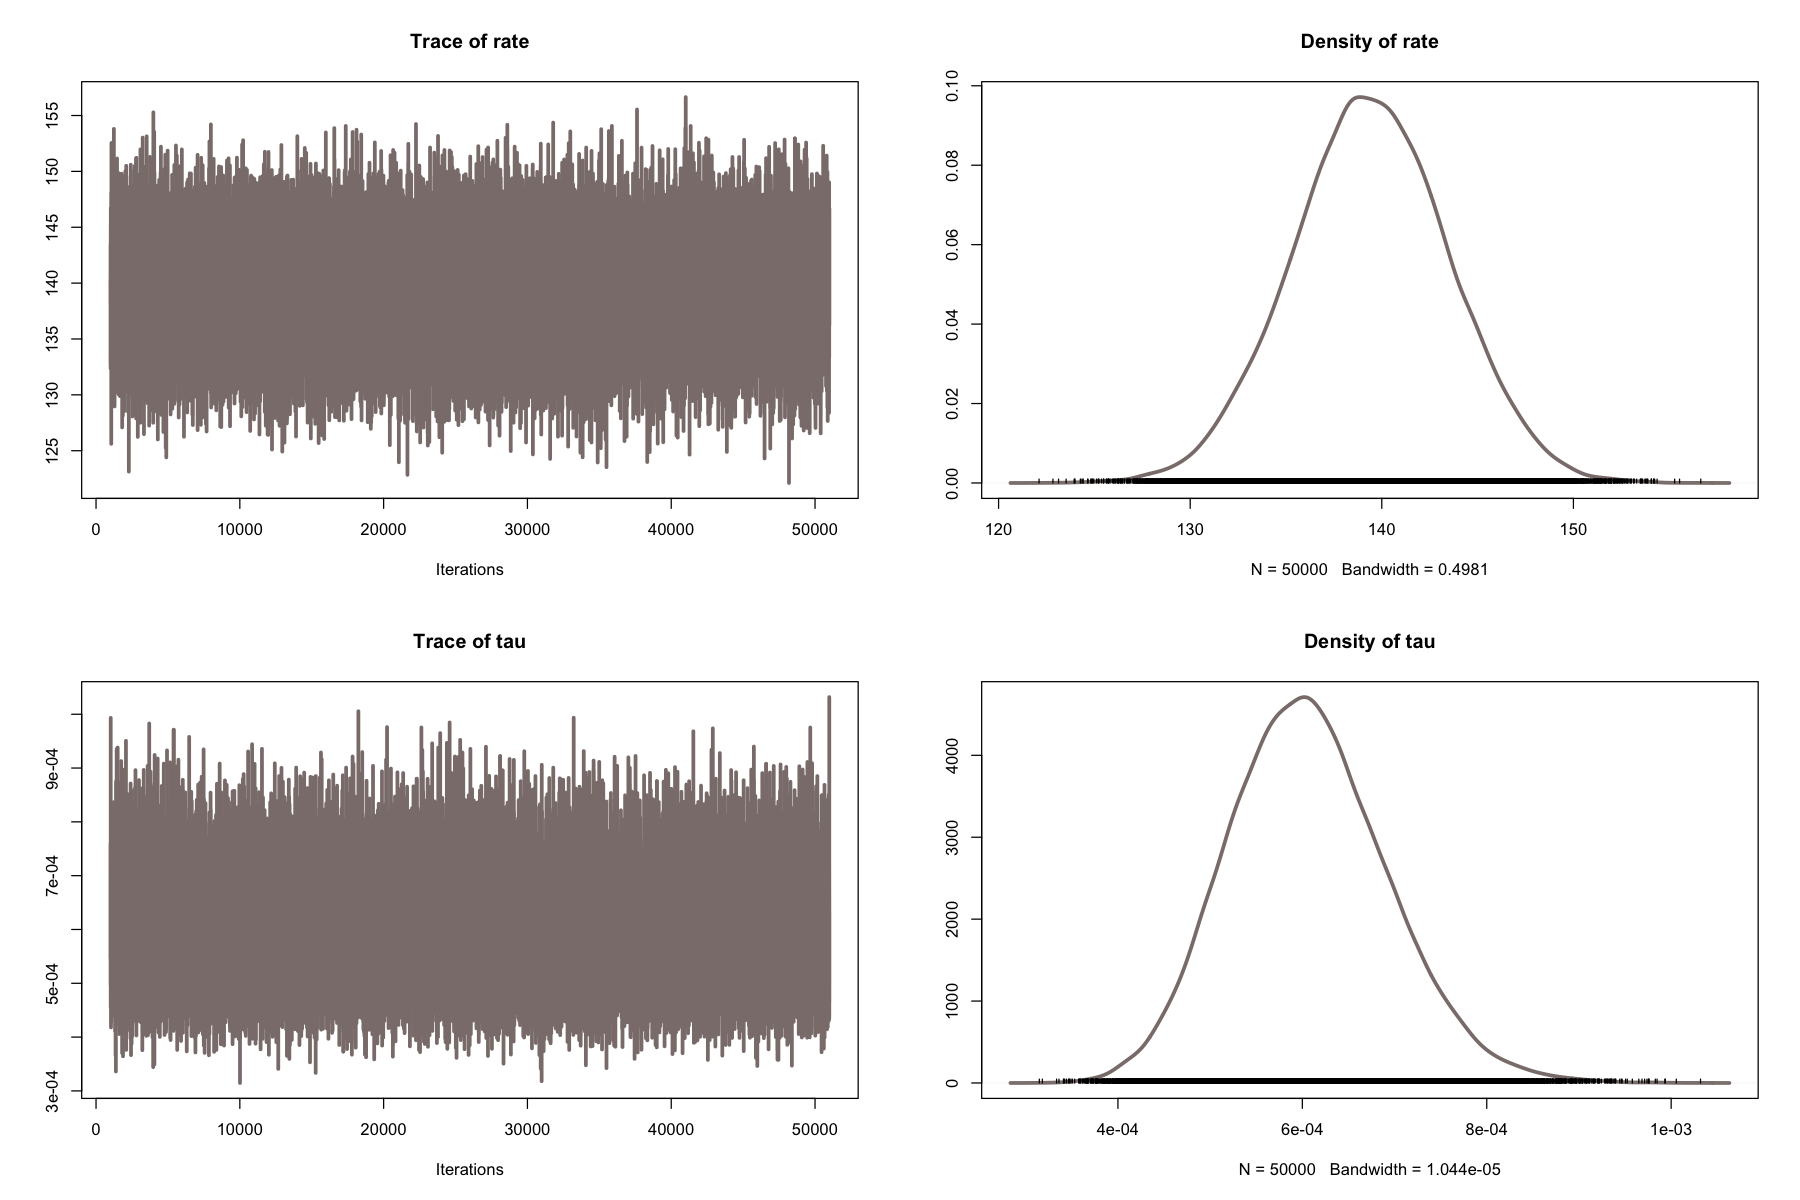

In [15]:
plot(chain_dnorm, col='mistyrose4', lwd=3)

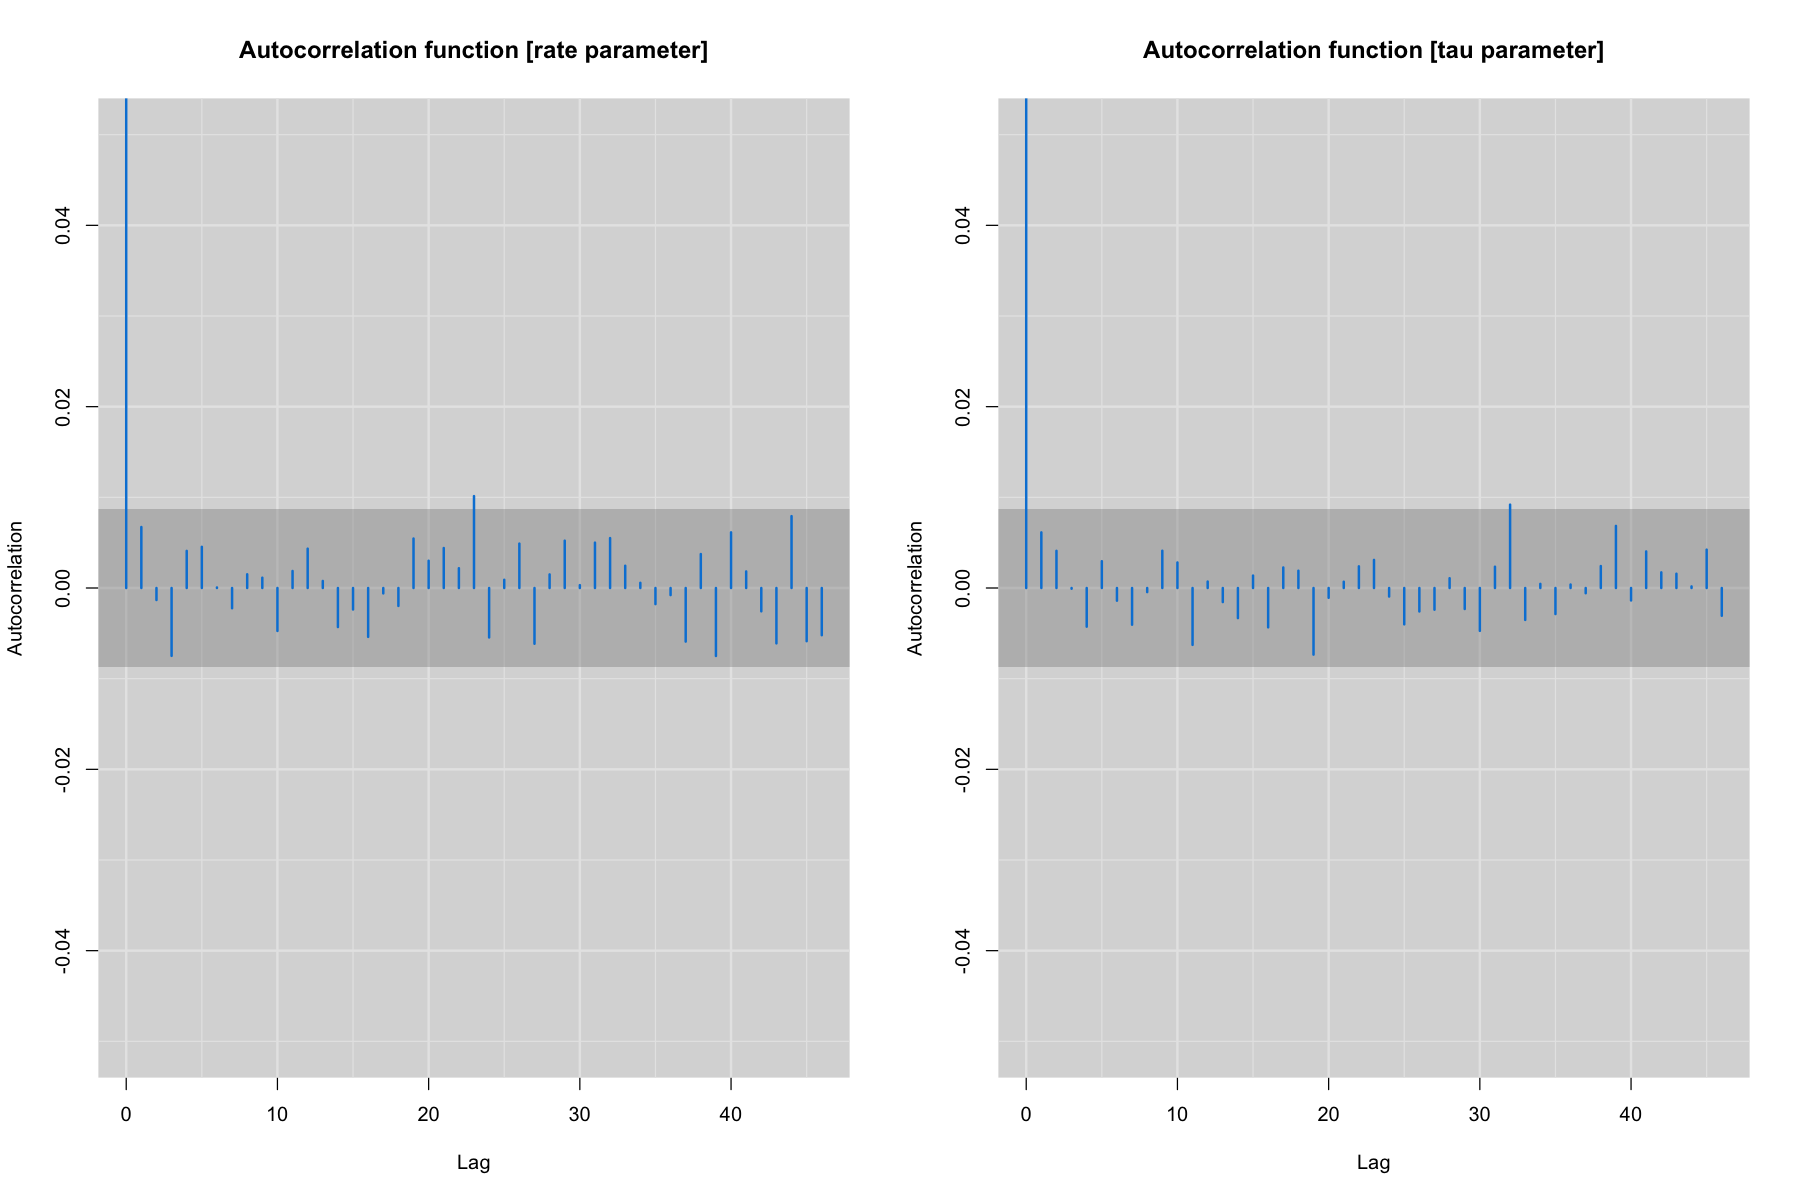

In [16]:
par(mfrow=c(1,2))
autplot1(chain_dnorm[,1],  ylim=c(-0.05,0.05), style='gray', main='Autocorrelation function [rate parameter]')
autplot1(chain_dnorm[,2],  ylim=c(-0.05,0.05), style='gray', main='Autocorrelation function [tau parameter]')

### Chain inspection -  Answered

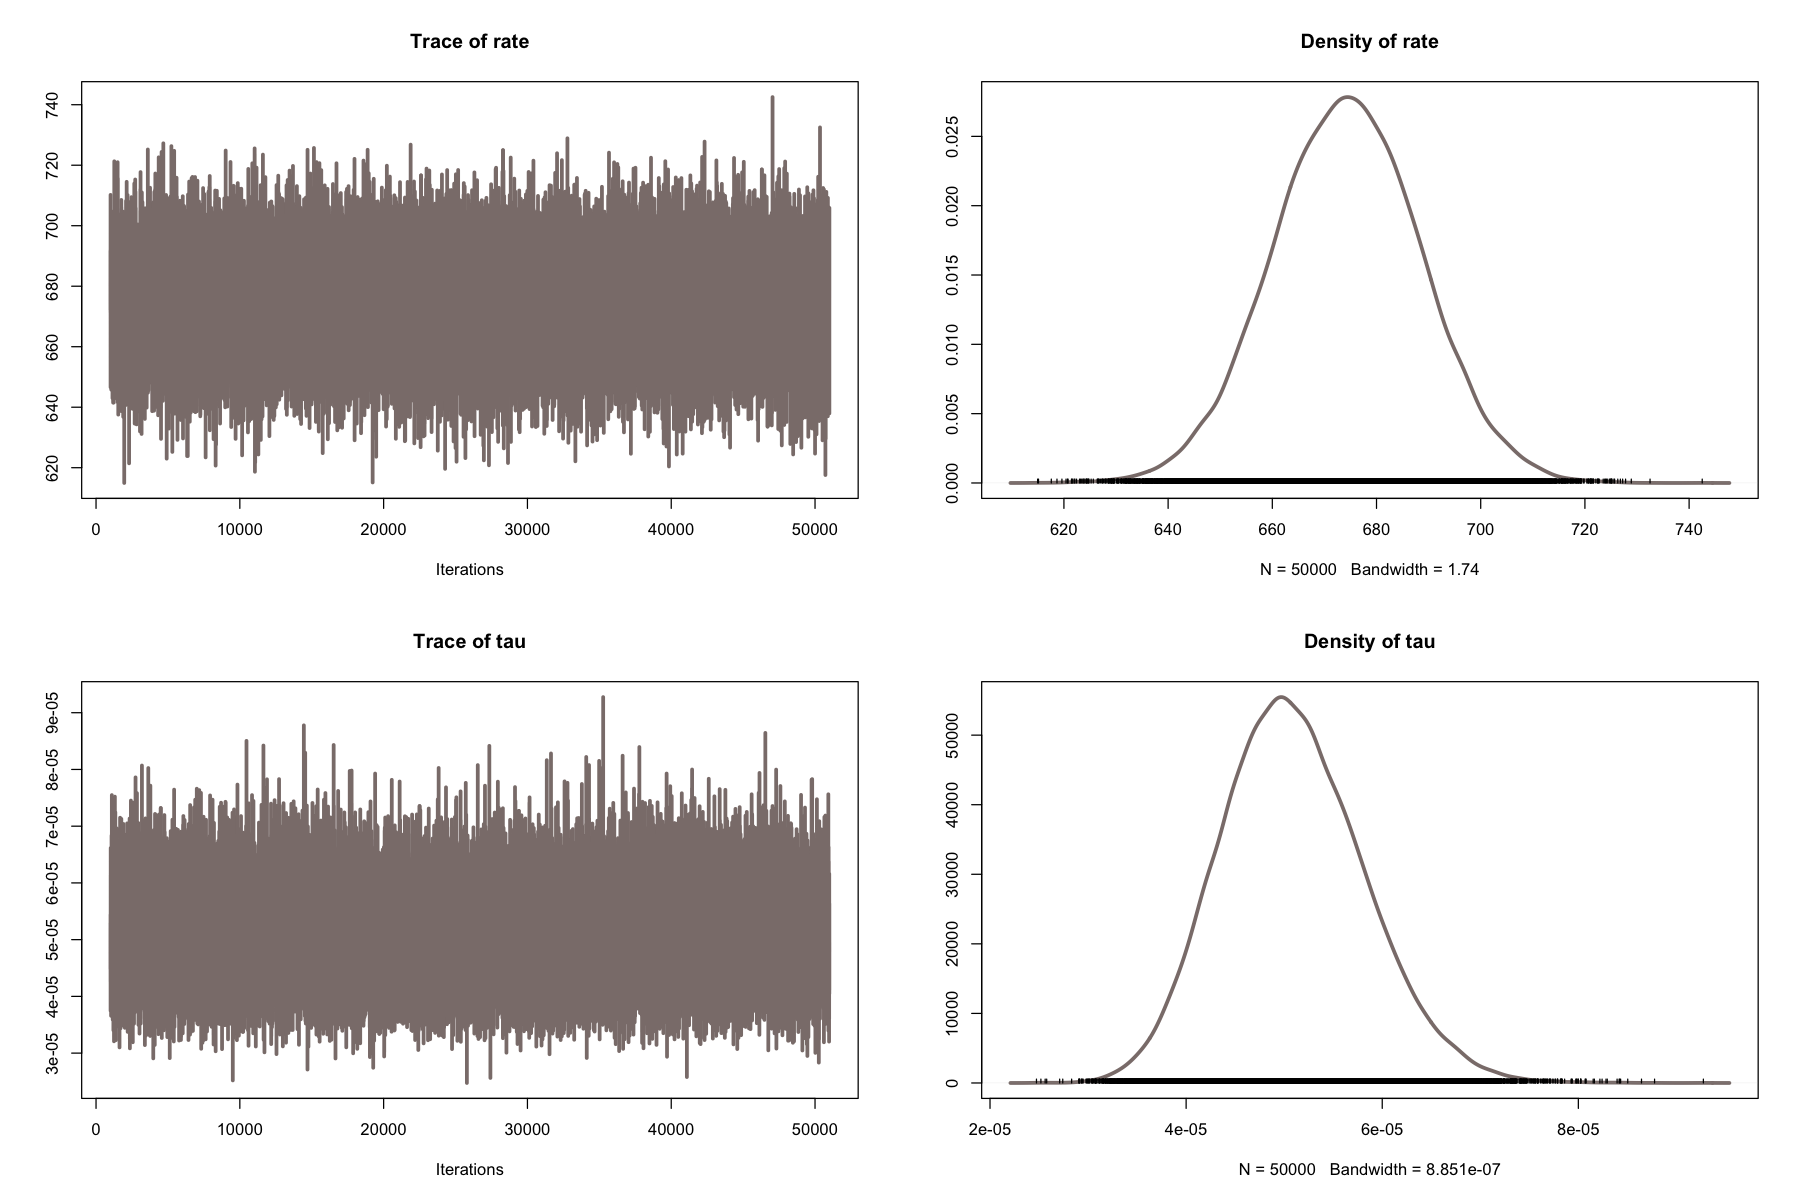

In [17]:
plot(chain_dnorm_ris, col='mistyrose4', lwd=3)

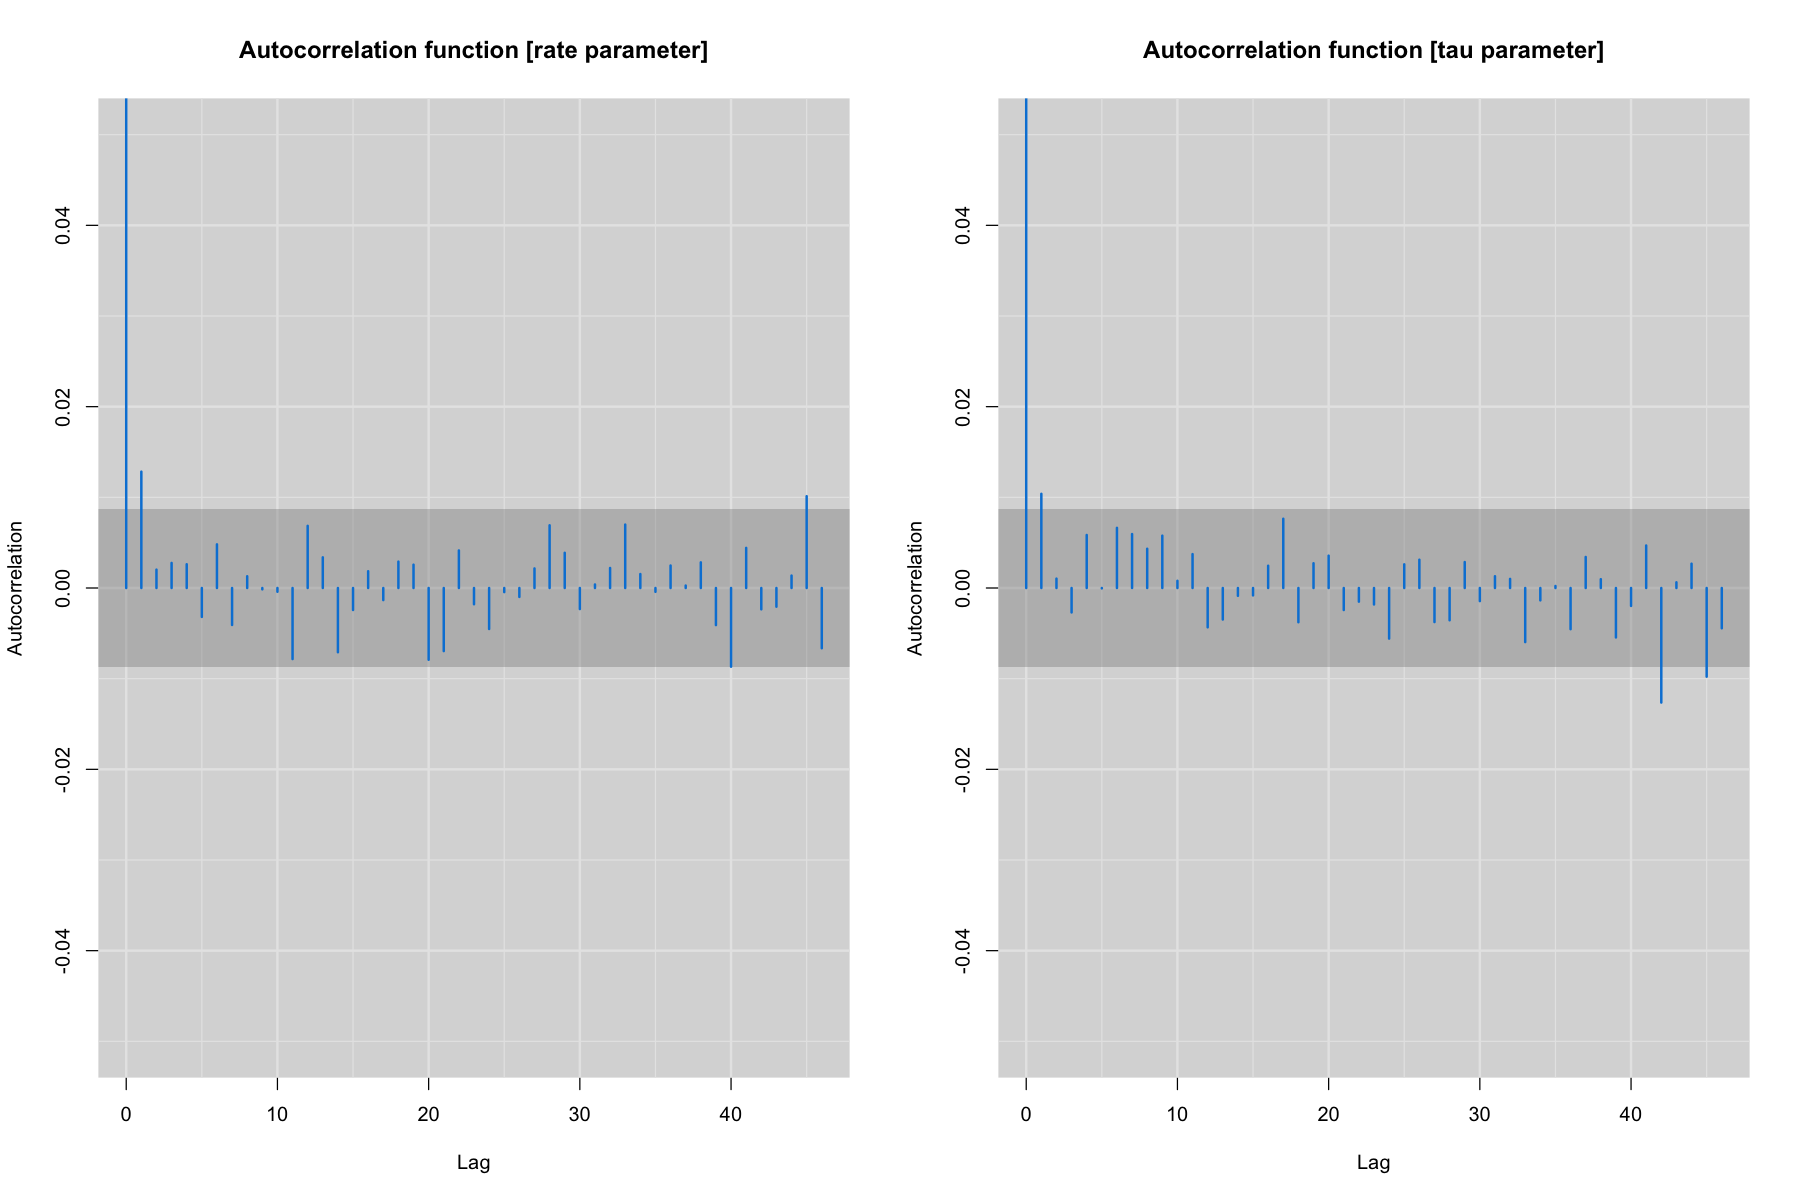

In [18]:
par(mfrow=c(1,2))
autplot1(chain_dnorm_ris[,1],  ylim=c(-0.05,0.05), style='gray', main='Autocorrelation function [rate parameter]')
autplot1(chain_dnorm_ris[,2],  ylim=c(-0.05,0.05), style='gray', main='Autocorrelation function [tau parameter]')

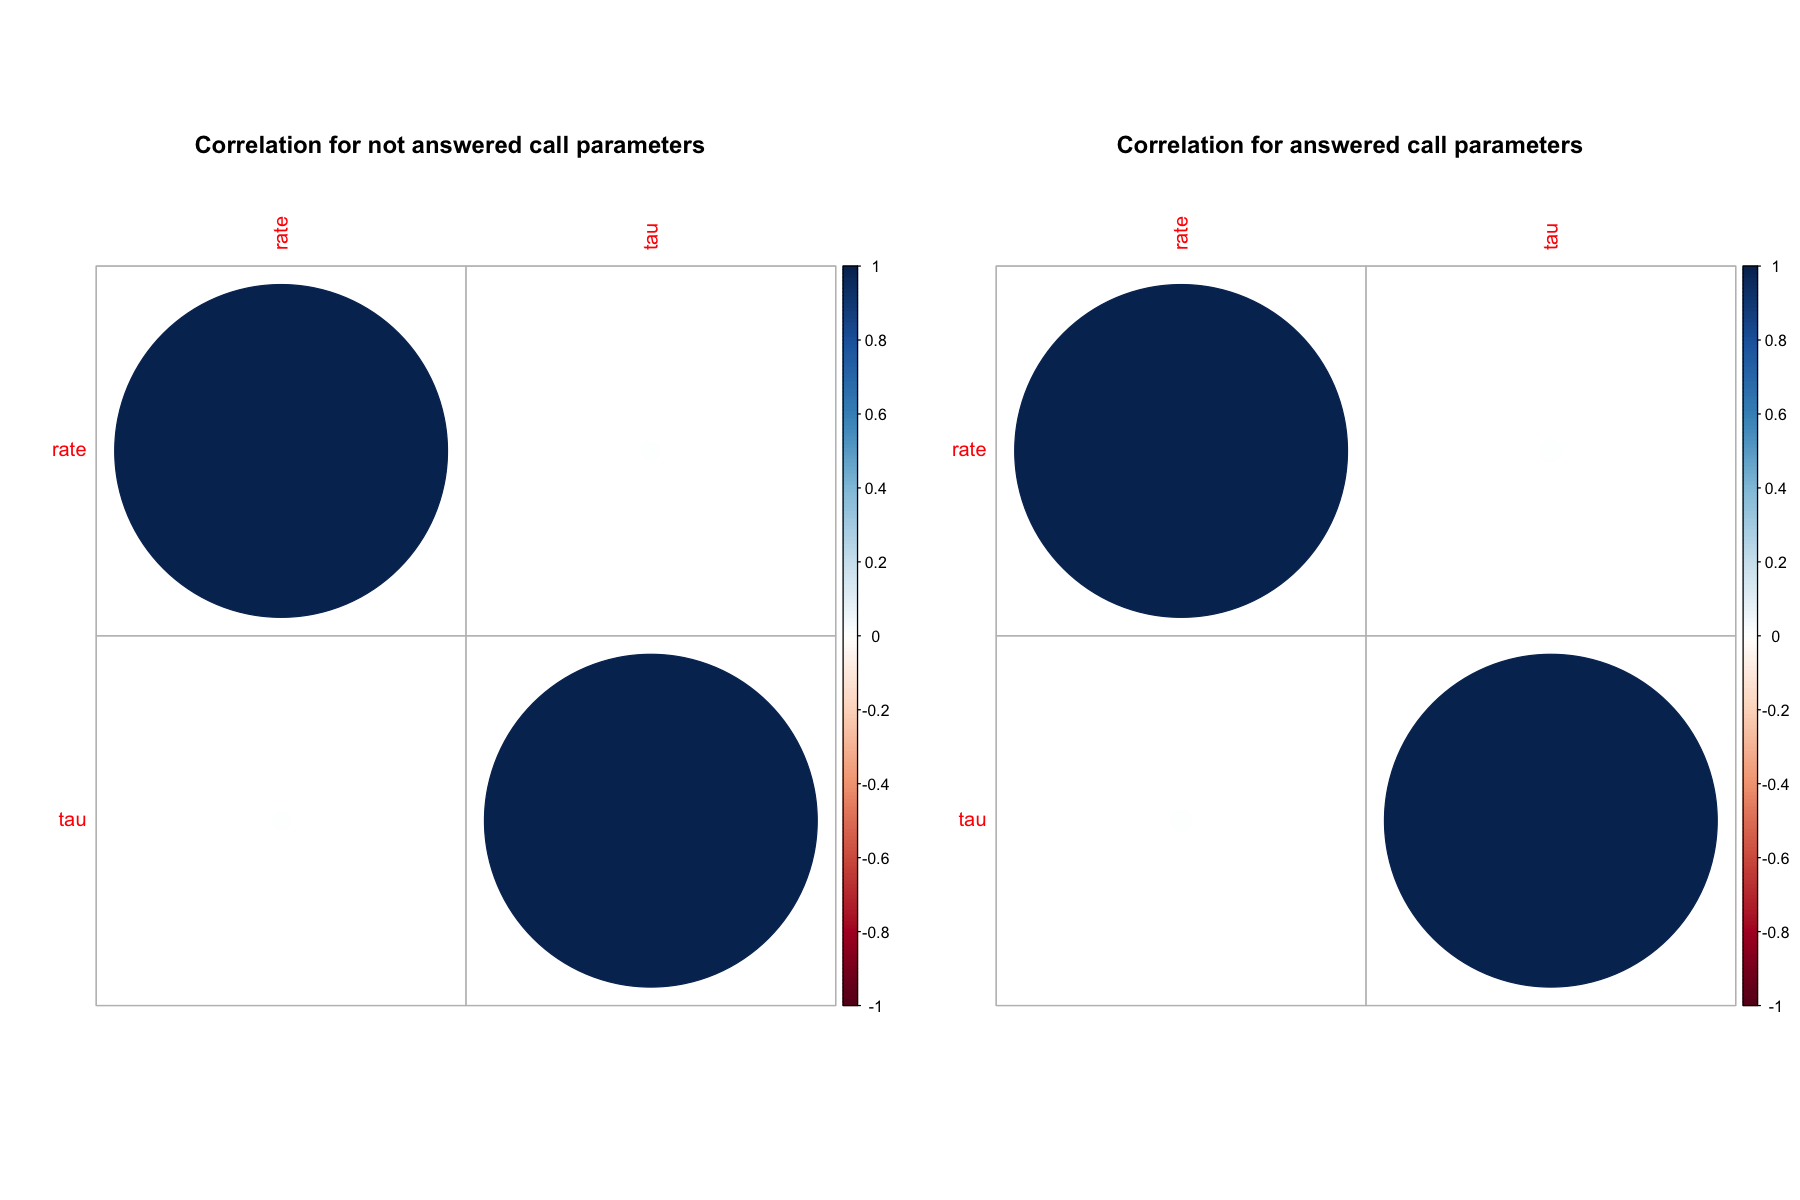

In [19]:
par(mfrow=c(1,2))
corrplot(crosscorr(as.mcmc(chain_dnorm_ris)), main='\n\n\n\n\n\n\n\n\n\nCorrelation for not answered call parameters')
corrplot(crosscorr(as.mcmc(chain_dnorm)), main='\n\n\n\n\n\n\n\n\n\nCorrelation for answered call parameters')

## 2. Bayesian Network

### Dependencies
We now try to make some hypothesis on relationship between features in the dataset. We would like to study how the call duration is affected by other variables. In our mind, we imagine the following connections:
* $T\rightarrow D$ We expect that longer calls are in some specific hours of the day;
* $AH\rightarrow D$ We expect that some agents make longer calls than others;
* $CC (AC)\rightarrow D$ We expect that it takes more time to talk with callers from foreing countries; 
<img src="diagram-20210605.png">

Bayesian networks are the perfect framework to exploit the dependence between variables.


In [20]:
#Hashing data and rescaling into the [0,1] interval.
#v_Minutes_Hashed_IT will be the starting point for the following JAGS simulations.
v_Minutes_Hashed = hour( ymd_hms(df_v[['Initiation Timestamp']]))*60 + minute( ymd_hms(df_v[['Initiation Timestamp']]))
v_Minutes_Hashed = v_Minutes_Hashed/(24*60)

#Definition of dataframe for bayesian network
df_bn <- data.frame(Duration =  df_v[['Agent interaction duration']], Time = v_Minutes_Hashed, 
                    Agent = df_v['Agent hashed'],
                    Country = df_v['Customer_Country_Code'], System = df_v['System Phone Number'])
#df_bn[1:10,]

#Transform to 24 hour format and binning them in 6 time periods
df_bn$Time=round(df_bn$Time*24,0)%/%4

#Binning the call duration in multiples of 3 minuts
df_bn$Duration=3*df_bn$Duration%/%180

#Renaming the dataframe for the following bayesian network fit
names(df_bn)=c('D','T','AH','CC','AC')

In [21]:
# Factorizing data in order to use bnlearn fit with discrete probability distributions
df_bn$AH = as.factor(df_bn$AH)
df_bn$CC = as.factor(df_bn$CC)
df_bn$AC = as.factor(df_bn$AC)
df_bn$D = as.factor(df_bn$D)
df_bn$T = as.factor(df_bn$T)
df_bn=df_bn[-5]

We remove the feature *AC* because it creates problem in the fit phase. The issues are probabily due to the fact that in the dataset some combinations *AC-CC* do not exist and the algorithm is not able to fit the network using the given data.

In [22]:
# Checking if the the two variables are actually correlated

ci.test("D", "CC", test = "mi", data = df_bn )
#ci.test("D", "AC", test = "mi", data = df_bn )
ci.test("D", "T", test = "mi", data = df_bn )
ci.test("D", "AH", test = "mi", data = df_bn )


	Mutual Information (disc.)

data:  D ~ CC  
mi = 2668.4, df = 576, p-value < 2.2e-16
alternative hypothesis: true value is greater than 0



	Mutual Information (disc.)

data:  D ~ T  
mi = 250.86, df = 54, p-value < 2.2e-16
alternative hypothesis: true value is greater than 0



	Mutual Information (disc.)

data:  D ~ AH  
mi = 15152, df = 954, p-value < 2.2e-16
alternative hypothesis: true value is greater than 0


Here, the p-values are all very small, meaning that there might exist some **strong** connections between the variables.

Loading required namespace: Rgraphviz

The network has a score of-1525988



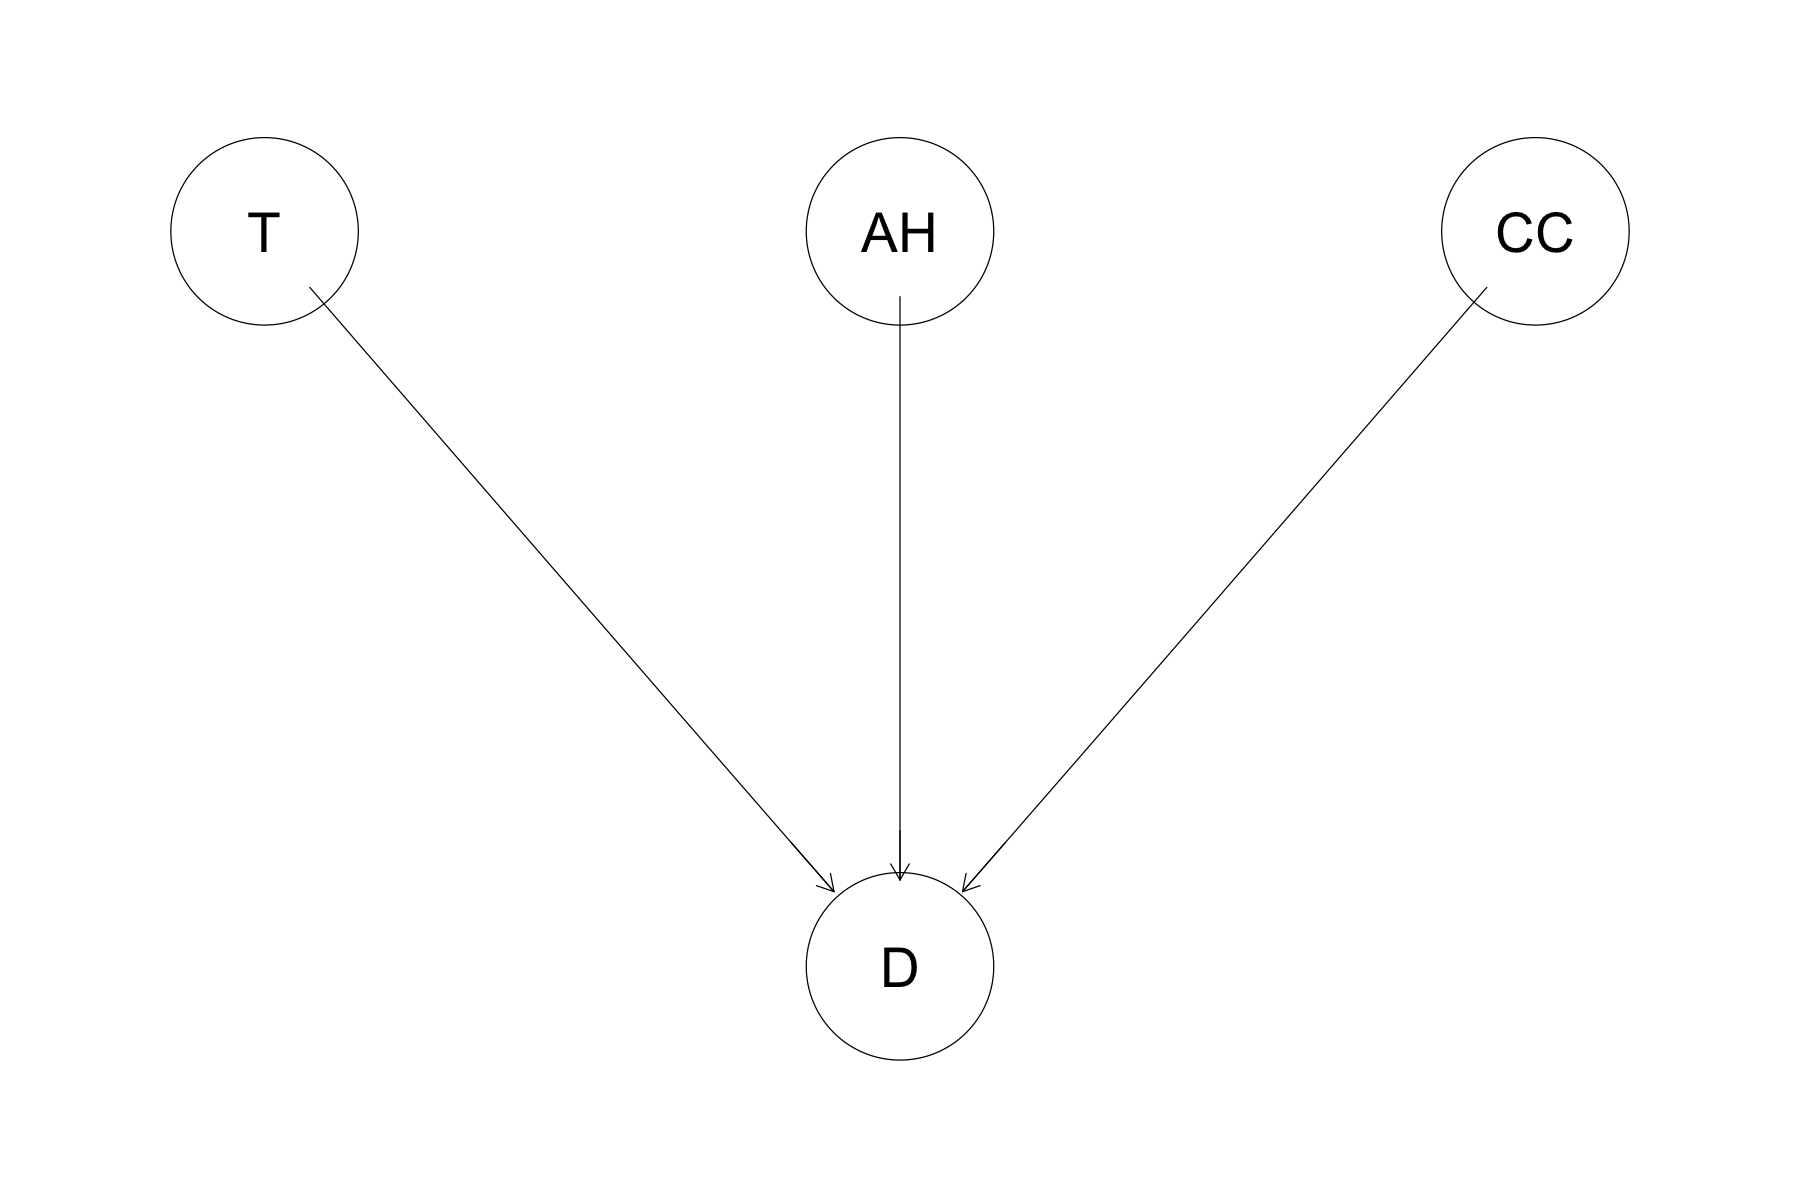

In [23]:
# Creating the network
netw = empty.graph(nodes = c("T",'AH',"D","CC"))
netw = set.arc(netw, from='AH', to='D')
netw = set.arc(netw, from='CC', to='D')
netw = set.arc(netw, from='T', to='D')
graphviz.plot(netw)

message("The network has a score of",round(score( netw , data = df_bn , type = "bic"),0))

The computed score is low, we try to remove some variables and see what happens to the global score. We can, for example, remove the dependence on the customer country *CC* and calculate the score for the new network.

The network has a score of-638689



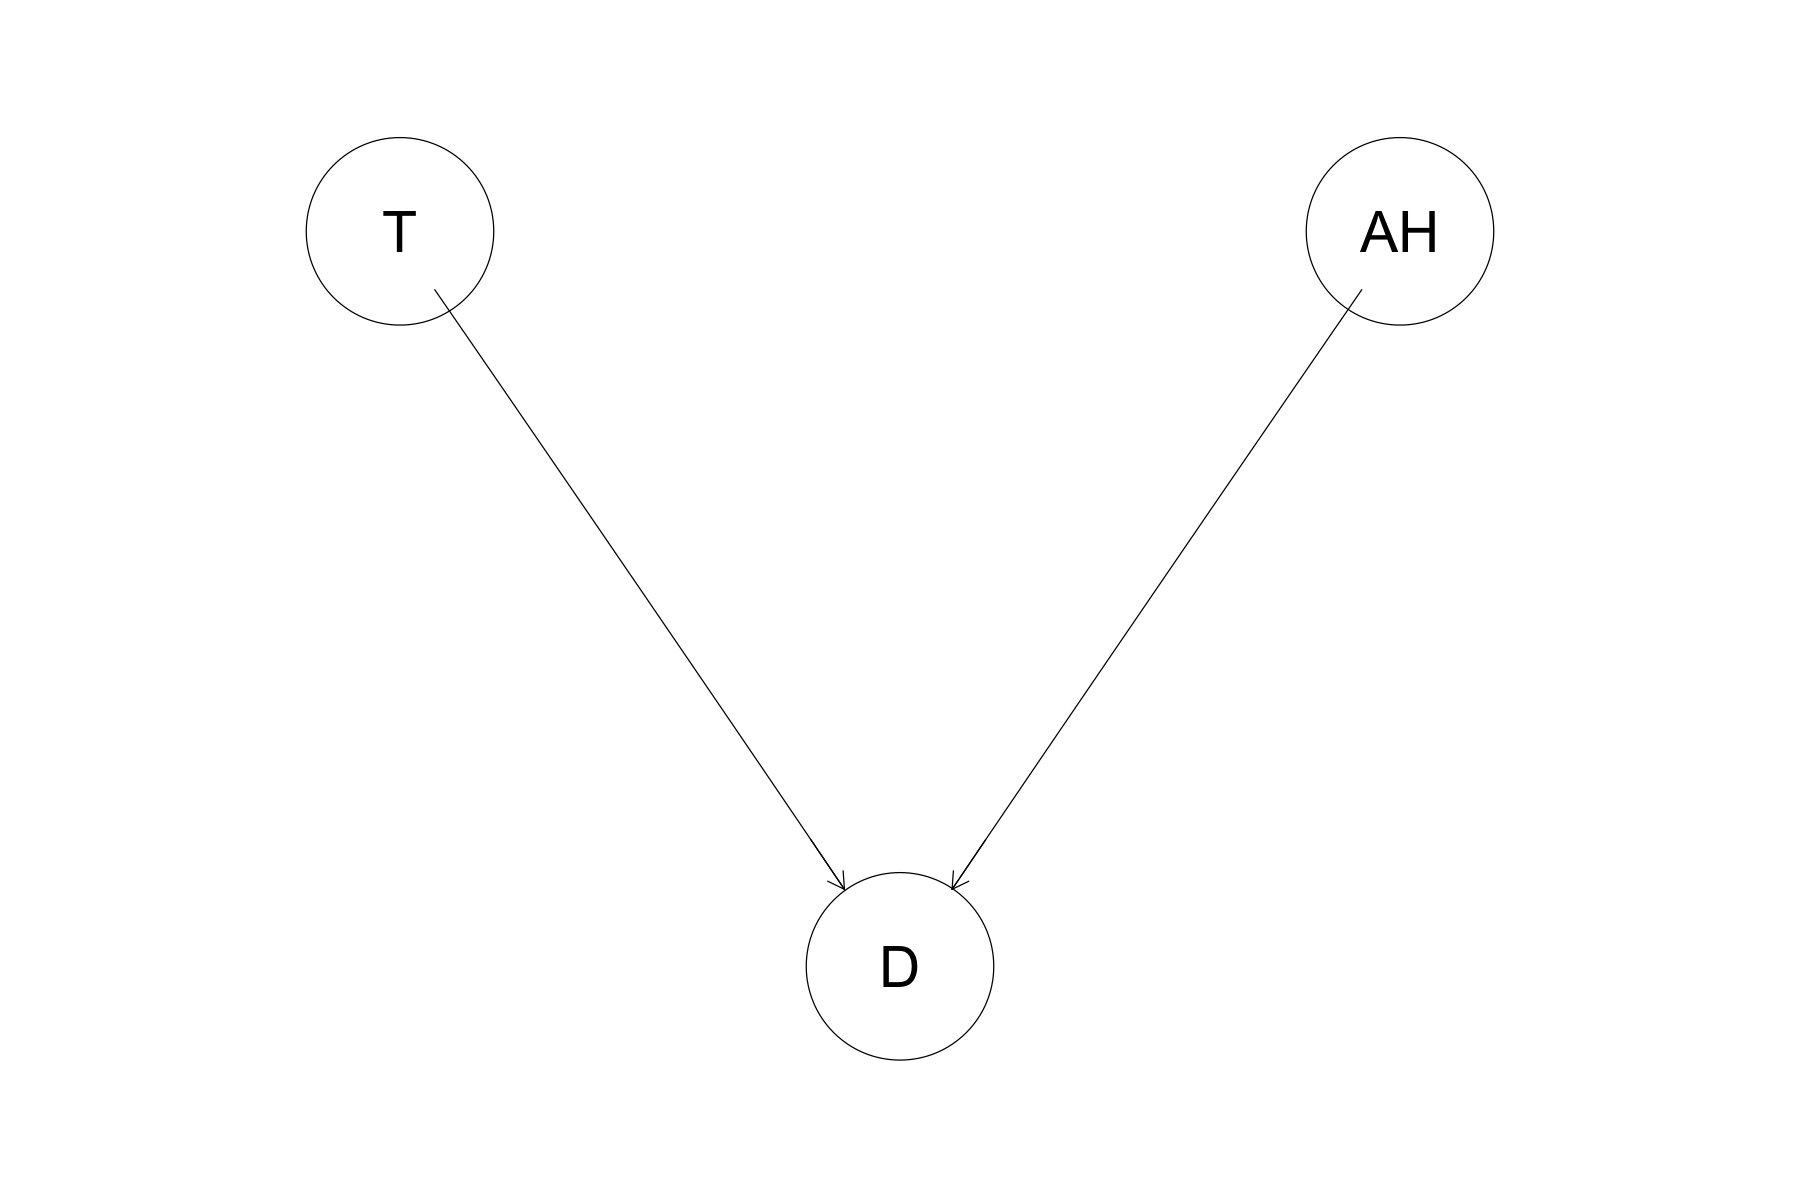

In [24]:
df_bn=df_bn[-4]

netw = empty.graph(nodes = c("T",'AH',"D"))
netw = set.arc(netw, from='AH', to='D')
netw = set.arc(netw, from='T', to='D')
graphviz.plot(netw)
message("The network has a score of",round(score( netw , data = df_bn , type = "bic"),0))

The network score improves if customer country *CC* is removed, and so the final network has only three nodes.

In [25]:
# Fitting the network using data

bn.res =bn.fit(netw, data=df_bn, method="bayes")

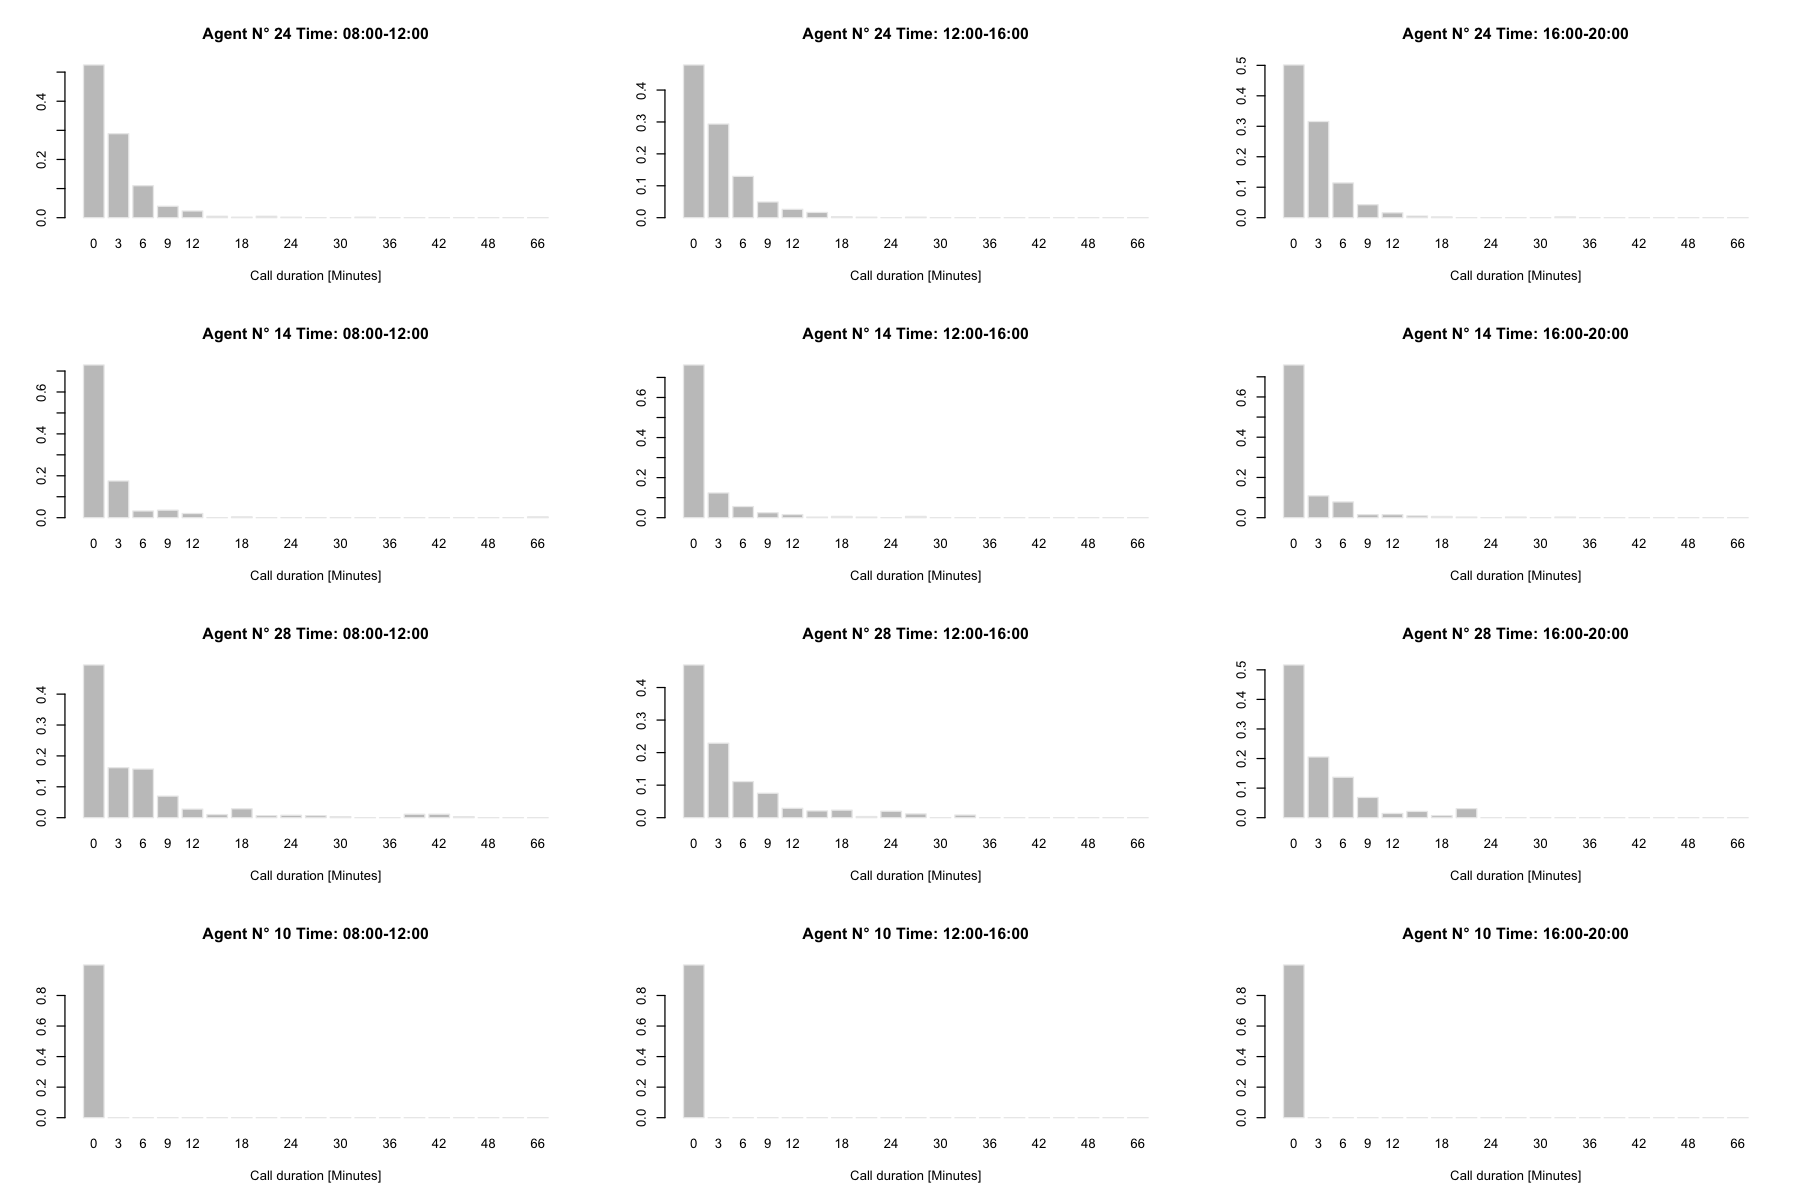

In [26]:
layout(matrix(c(1:12), nrow = 4, ncol = 3, byrow = TRUE))
agent_plot <- function(agent.number){
    barplot(bn.res$D$prob[,1,agent.number], main = paste("Agent N°",agent.number,"Time: 08:00-12:00"), xlab = "Call duration [Minutes]",col = rgb(0.75,0.75,0.75,alpha=0.9), border = rgb(0.92,0.92,0.92,alpha=1))
    barplot(bn.res$D$prob[,2,agent.number], main = paste("Agent N°",agent.number,"Time: 12:00-16:00"), xlab = "Call duration [Minutes]", col = rgb(0.75,0.75,0.75,alpha=0.9), border = rgb(0.92,0.92,0.92,alpha=1))
    barplot(bn.res$D$prob[,3,agent.number], main = paste("Agent N°",agent.number,"Time: 16:00-20:00"), xlab = "Call duration [Minutes]",col = rgb(0.75,0.75,0.75,alpha=0.9), border = rgb(0.92,0.92,0.92,alpha=1))
}

agent_plot(24)
agent_plot(14)
agent_plot(28)
agent_plot(10)

## 3. COVID Analysis

We discuss now how daily call number distribution changed in two different time periods: July 2019 and March 2021. 

In [27]:
#Getting data from previously decided time periods
df_v_it_cov = subset(df_v, df_v["Customer_Country_Code"] == 'IT')

df_jul = subset(df_v_it_cov,df_v_it_cov[["Initiation Timestamp"]]<ymd("2020-01-01"))
df_mar = subset(df_v_it_cov,(df_v_it_cov[["Initiation Timestamp"]]>ymd("2021-03-01")) & (df_v_it_cov[["Initiation Timestamp"]]<ymd("2021-03-31")))
    
#Calculating call frequency during the two time periods previously chosen
counts_mar = table(day(df_mar[["Initiation Timestamp"]]))[-16]
counts_jul = table(day(df_jul[["Initiation Timestamp"]]))

The distribution chosen to model these two dataset is again a gaussian with standard deviation coming from data. The prior used is gaussian too and has a standard deviation of 40, coming from considerations made by the IT service.

In [28]:
n.sample <- 4000
mu <- seq(400,750,length.out=n.sample)
delta.mu <- mu[2]-mu[1]

N_m <- length(counts_mar)
y.bar_m <- mean(counts_mar)

N_j <- length(counts_jul)
y.bar_j <- mean(counts_jul)

sigma.sq_j <- sd(counts_jul)**2
sigma.sq_m <- sd(counts_mar)**2

s.sq <- (40**2)
m_j <- 500
m_m <- 650
# Compute mean and sd for the Posterior for both the data coming from March 2021 and July 2019
mu.post_j <- (1/s.sq) / (N_j/sigma.sq_j + 1/s.sq) * m_j + (N_j/sigma.sq_j) /
                                (N_j/sigma.sq_j + 1/s.sq) * y.bar_j
mu.post_m <- (1/s.sq) / (N_m/sigma.sq_m + 1/s.sq) * m_m + (N_m/sigma.sq_m) /
                                (N_m/sigma.sq_m + 1/s.sq) * y.bar_m

sd.sq.post_j <- (sigma.sq_j * s.sq) / (sigma.sq_j + N_j * s.sq)
sd.sq.post_m <- (sigma.sq_m * s.sq) / (sigma.sq_m + N_m * s.sq)

# Determine the Priors
norm.prior_j <- dnorm(mu,mean=m_j,sd=sqrt(s.sq))
norm.prior_m <- dnorm(mu,mean=m_m,sd=sqrt(s.sq))


# Determine the Posteriors
norm.post_j <- dnorm(mu,mean=mu.post_j,sd=sqrt(sd.sq.post_j))
norm.post_m <- dnorm(mu,mean=mu.post_m,sd=sqrt(sd.sq.post_m))

#Interval estimation
minq_j <- qnorm(0.025,mean=mu.post_j,sd=sqrt(sd.sq.post_j))
minq_m <- qnorm(0.025,mean=mu.post_m,sd=sqrt(sd.sq.post_m))
maxq_j <- qnorm(0.975,mean=mu.post_j,sd=sqrt(sd.sq.post_j))
maxq_m <- qnorm(0.975,mean=mu.post_m,sd=sqrt(sd.sq.post_m))

diff = dnorm(seq(0,300,length.out = n.sample),mu.post_m-mu.post_j,sd= sqrt(sd.sq.post_j+sd.sq.post_m))

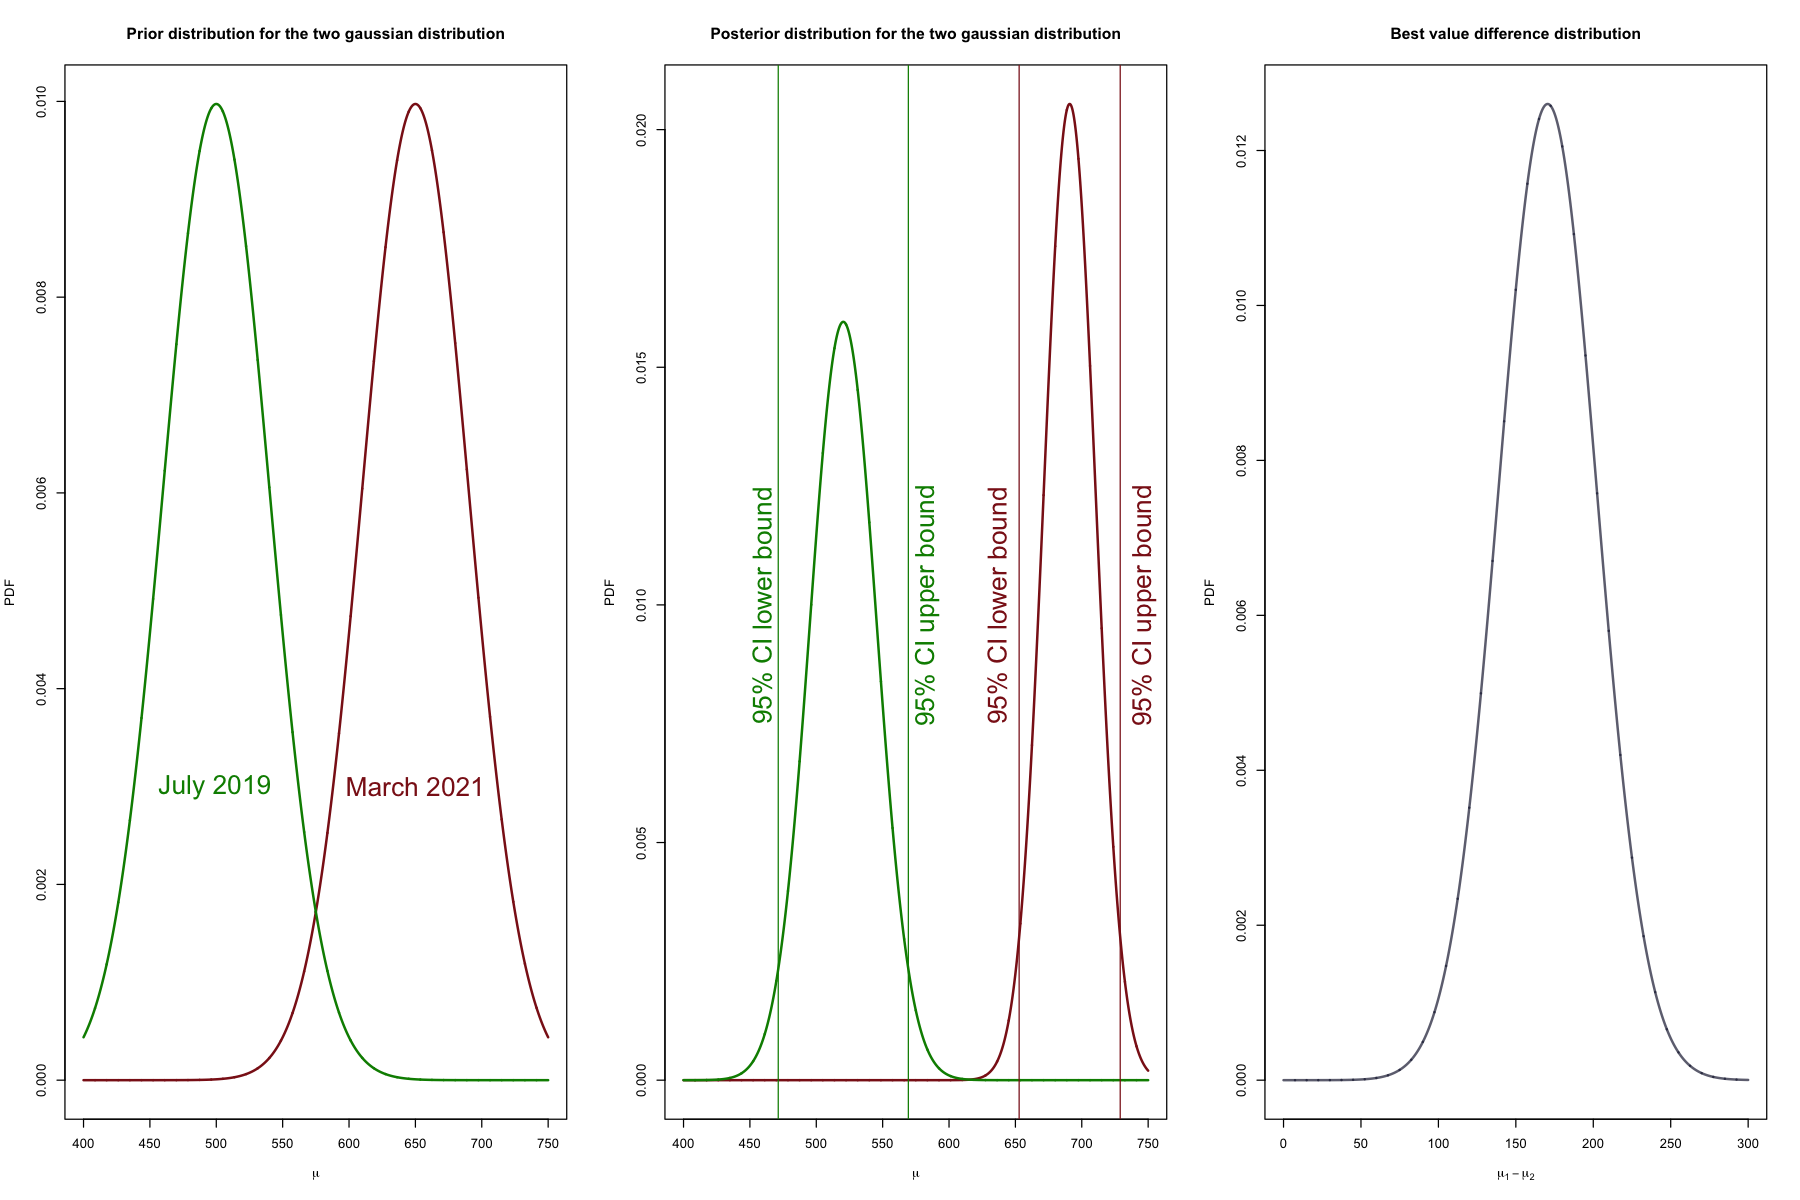

In [29]:
par(mfrow=c(1,3))
plot(mu,norm.prior_m, main = 'Prior distribution for the two gaussian distribution',
     xlab = TeX('$\\mu$'), ylab = 'PDF', t = 'l', lwd = 2, col = "firebrick4")
lines(mu,norm.prior_j, t = 'l', lwd = 2, col = "green4")

text(499,0.003, "July 2019", cex =2, col = 'green4')
text(650,0.003, "March 2021", cex =2, col = 'firebrick4')

plot(mu,norm.post_m, main = 'Posterior distribution for the two gaussian distribution',
     xlab = TeX('$\\mu$'), ylab = 'PDF', t = 'l', lwd = 2, col = "firebrick4")
lines(mu,norm.post_j, t = 'l', lwd = 2, col = "green4")

abline(v = minq_j, col = 'green4')
abline(v = minq_m, col = 'firebrick4')
abline(v = maxq_j, col = 'green4')
abline(v = maxq_m, col = 'firebrick4')

text( minq_j-minq_j/40, 0.01, "95% CI lower bound", cex =2, srt= 90, col = "green4")
text( maxq_j+maxq_j/40, 0.01, "95% CI upper bound", cex =2, srt= 90, col = "green4")

text( minq_m-minq_m/40, 0.01, "95% CI lower bound", cex =2, srt= 90, col = "firebrick4")
text( maxq_m+maxq_m/40, 0.01, "95% CI upper bound", cex =2, srt= 90, col = "firebrick4")

text(470,0.037, "July 2019", cex =2, col = 'green4')
text(470,0.04, "March 2021", cex =2, col = 'firebrick4')

plot(seq(0,300,length.out = n.sample),diff, main = 'Best value difference distribution',
     xlab = TeX('$\\mu_1-\\mu_2$'), ylab = 'PDF', t = 'l', lwd = 2, col = rgb(0.12,0.13,0.25, alpha = 0.7))

In [30]:
message("Results for July 2019")
message("The mean of the gaussian posterior distribution is: ", round(mu.post_j,0) , " with standard deviation: ", round(sqrt(sd.sq.post_j), 0))
message("The 95% CI corresponds to mean times in the [", round(minq_j,0),", " ,round(maxq_j,0), "] interval.")

Results for July 2019

The mean of the gaussian posterior distribution is: 520 with standard deviation: 25

The 95% CI corresponds to mean times in the [471, 569] interval.



In [31]:
message("Results for March 2021")
message("The mean of the gaussian posterior distribution is: ", round(mu.post_m,0) , " with standard deviation: ", round(sqrt(sd.sq.post_m), 0))
message("The 95% CI corresponds to mean times in the [", round(minq_m,0),", " ,round(maxq_m,0), "] interval.")

Results for March 2021

The mean of the gaussian posterior distribution is: 691 with standard deviation: 19

The 95% CI corresponds to mean times in the [653, 729] interval.



The low number of data regarding **July 2019** doesn't allow a complete and affordable analysis, but we can see many differences between the two posteriors. Is noticeable that the frequency of calls increased in 2021 with respect to 2019 despite the Pandemic situation. In fact the company in these two years increased his **revenue** and his **sales**, with a consequent growth for the number of calls per day.

With more data, coming also from other years, a **deeper analysis** of the relation between calls, revenue and pandemic impact would have been possible. We set this last analysis as an outlook of this work.

## 4.  Call time distribution

## A. Arriving calls distribution

Let's now consider the amount of call arriving at **different times of the day** and analyze its distribution.

It may be useful also to sample data from such distrbution to **split shifts quantitatively**.

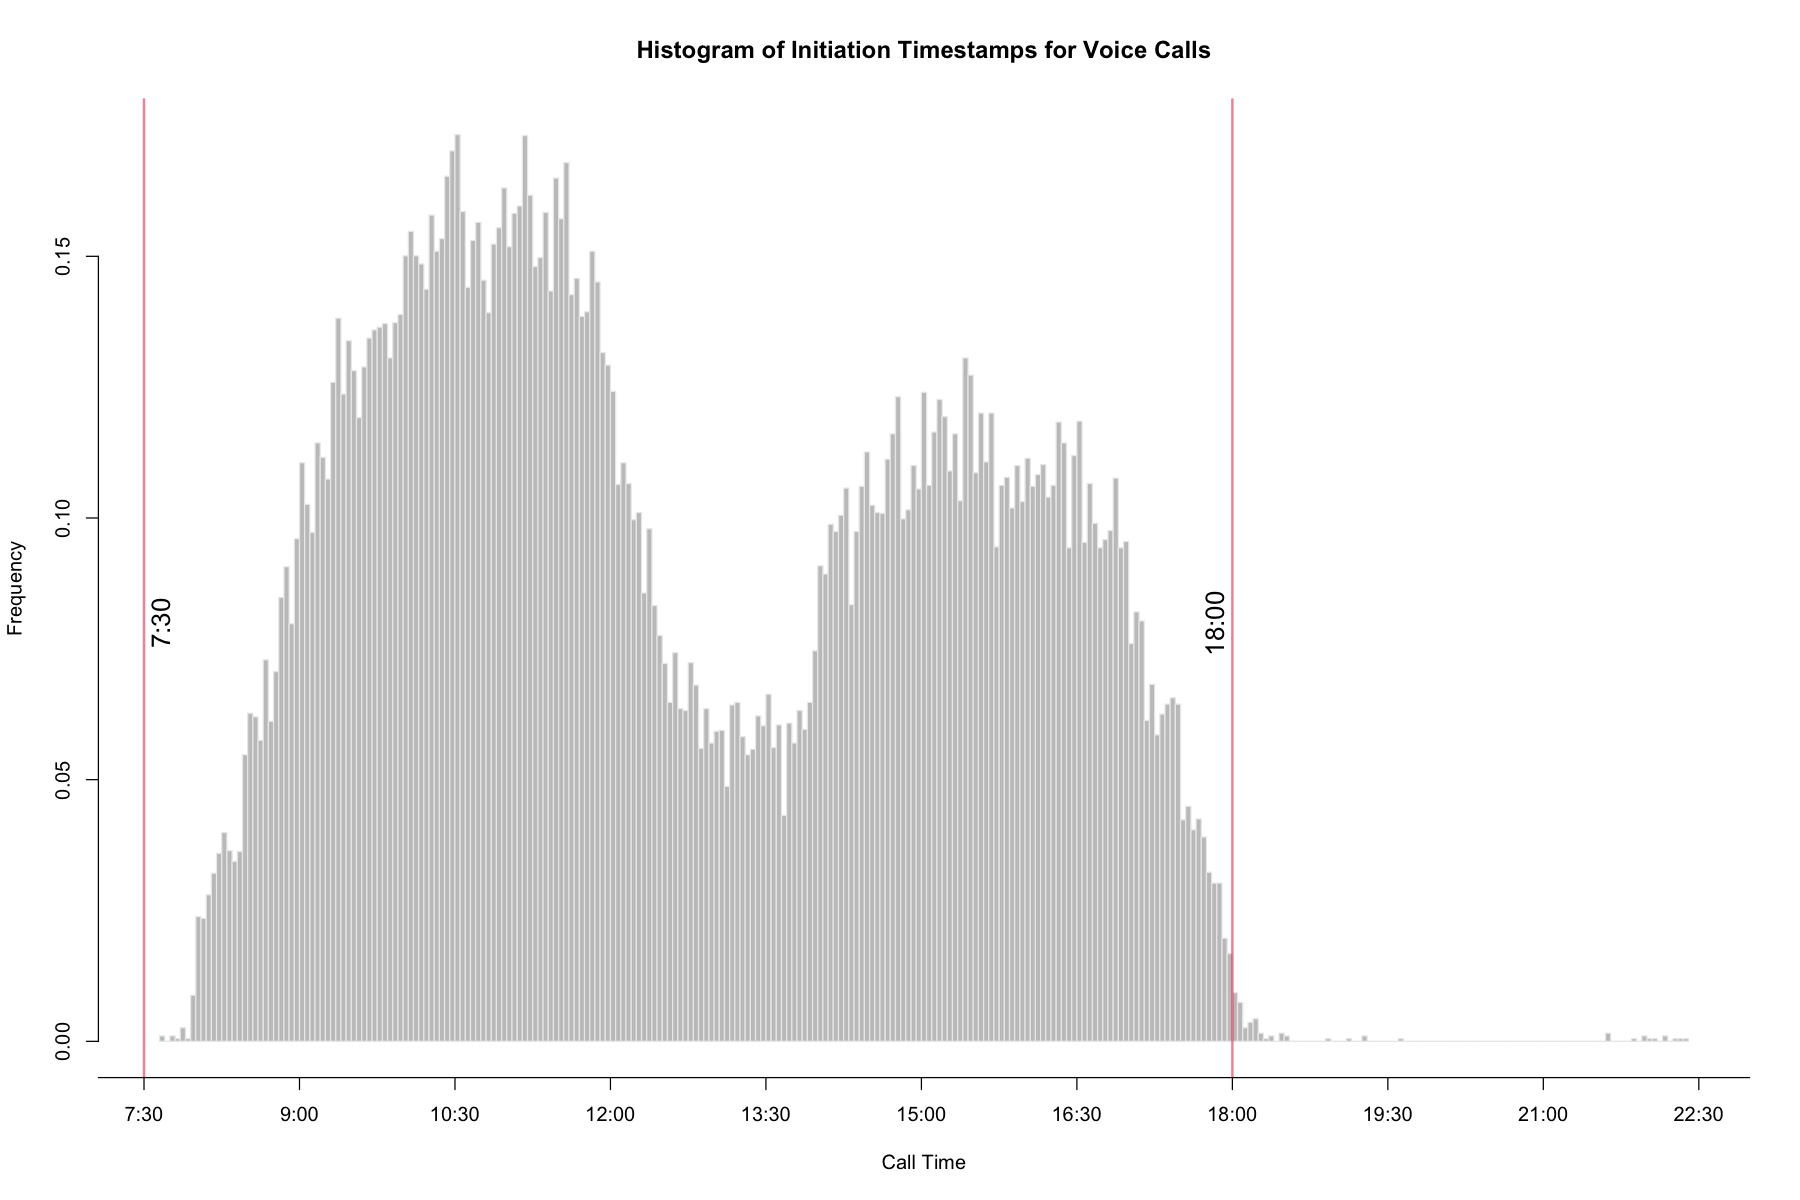

In [32]:
#hashing arrival times
v_Minutes_Hashed = hour(ymd_hms(df_v[['Initiation Timestamp']])) + minute(ymd_hms(df_v[['Initiation Timestamp']]))/60

hist(v_Minutes_Hashed, nc = 240, main = 'Histogram of Initiation Timestamps for Voice Calls', xlab = "Call Time", 
    ylab = 'Frequency', freq = FALSE, col = rgb(0.75,0.75,0.75,alpha=0.9), border = rgb(0.92,0.92,0.92,alpha=1),xaxt='n')

axis(side=1, at=seq(0,24,1.5), labels=paste0(trunc(seq(0,24,1.5)),c(rep(c(":00",":30"),8),":00")))

abline(v = 7.5, col = rgb(0.94,0.14,0.24,alpha=0.5), lwd = 2)
text(7.5+10/60,0.08, "7:30", cex =1.3, srt= 90)

abline(v = 18, col = rgb(0.94,0.14,0.24,alpha=0.5), lwd = 2)
text(18-10/60,0.08,"18:00", cex =1.3, srt= 90)

The histogram represents the **distribution of calls during a day**. The red lines correspond to beginning and ending of the working hours. This simple division shows how calls are concentrated between 7:30 and 18:00, with lower counts around 12:00/13:00 in correspondence of the usual lunch time.




Let's now select only the calls coming from **Italian customers**, the ones having a +39 in front of their number, already contained in the dataframe with the corresponding country code.


To improve calculations, the x-axis is then rescaled to fit in the **[0,1] interval**. This will be done for all the following operations.


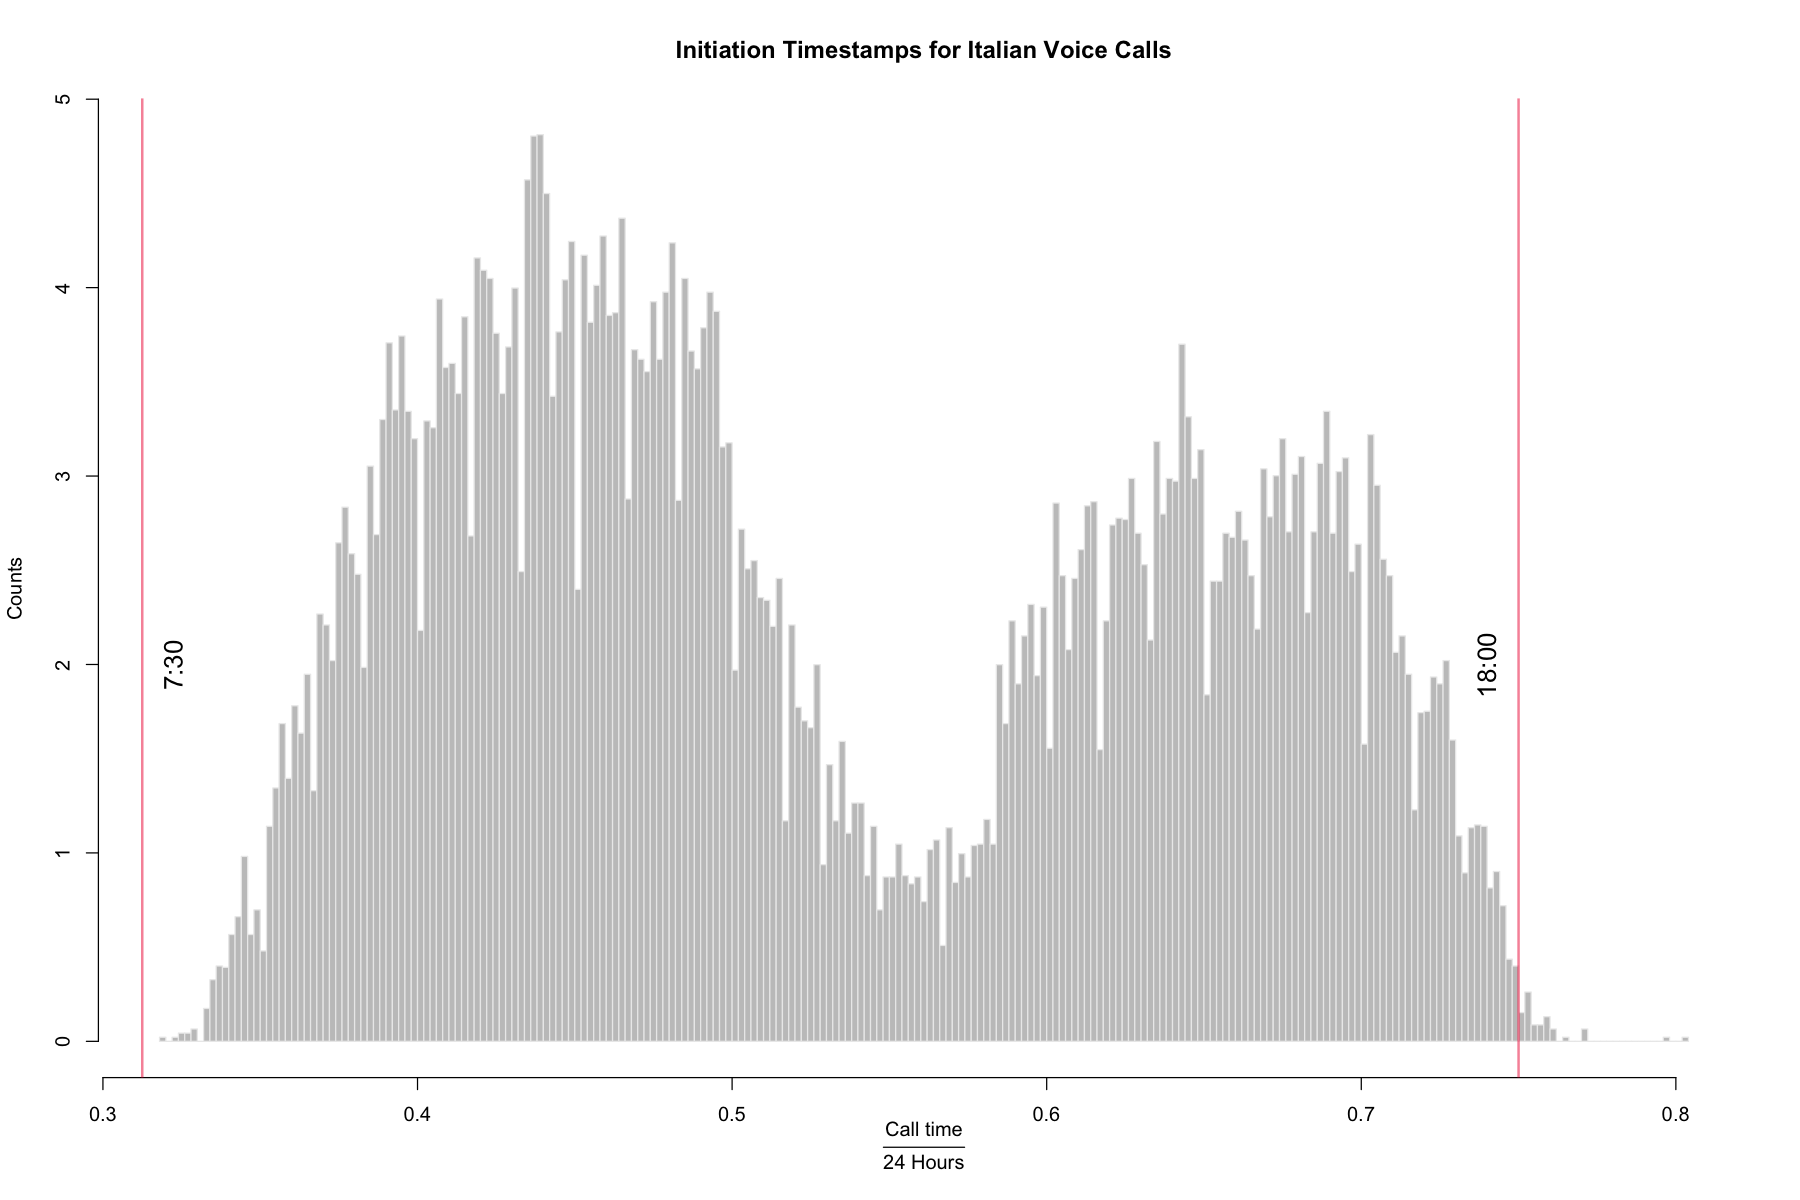

In [33]:
df_v_it = subset(df_v, df_v$Customer_Country_Code=='IT')

#hashing data and rescaling into the [0,1] interval.
#v_Minutes_Hashed_IT will be the starting point for the following JAGS simulations.
v_Minutes_Hashed_IT = hour( ymd_hms(df_v_it[['Initiation Timestamp']]))*60 +
                minute( ymd_hms(df_v_it[['Initiation Timestamp']]))
v_Minutes_Hashed_IT = v_Minutes_Hashed_IT/(24*60)

hist(v_Minutes_Hashed_IT, nc = 220, main = 'Initiation Timestamps for Italian Voice Calls', xlab = TeX('$\\frac{Call \\, time}{24 \\,Hours}$'), 
    ylab = 'Counts', col = rgb(0.75,0.75,0.75,alpha=0.9), border = rgb(0.92,0.92,0.92,alpha=1), freq = FALSE)

abline(v = 7.5/24, col = rgb(0.94,0.14,0.24,alpha=0.5), lwd = 2)
text(7.5/24+0.01,2, "7:30", cex =1.3, srt= 90)

abline(v = 18/(24), col = rgb(0.94,0.14,0.24,alpha=0.5), lwd = 2)
text(18/(24)-0.01,2,"18:00", cex =1.3, srt= 90)

The call distribution can be seen as the sum of two different PDFs, and  its peculiar bell shape leads to the assumption of either two **beta** or two **normal** distributions.

A new question now arises.. 

*Can we fit the entire distribution with two gaussians and then again describe the number of calls outside working hours using the resulting function?*


Let's now focus on **NOT ANSWERED** calls.

### B. JAGS sampling: Out of working hours calls with double gaussian model


The work is done using JAGS and a **two gaussian models** with **6 total parameters** (2 means, 2 sigmas, 2 pclust), and then the best result is compared to the data.

For compile-time reasons, only the **first 10000 calls** were considered in JAGS runs.

In [34]:
y = v_Minutes_Hashed_IT_NA[1:10000]
y = y[y>0.2]
N = length(y)

Nclust = 2
clust = rep(NA,N) 
clust[which.min(y)]=1 # smallest value assigned to cluster 1
clust[which.max(y)]=2 # highest value assigned to cluster 2

dataList = list(
    y = y ,
    N = N ,
    Nclust = Nclust ,
    clust = clust ,
    onesRepNclust = rep(1,Nclust)
)

jm_dnormNA <- jags.model('jags_doublenorm.txt', dataList)

update(jm_dnormNA, 1000)
coda_chain_dnormNA <- coda.samples(jm_dnormNA, c("tauOfClust", "muOfClust", "pClust"), n.iter=1000)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 9696
   Unobserved stochastic nodes: 9697
   Total graph size: 38785

Initializing model



model {

    # Likelihood:
    for( i in 1 : N ) {
	  
	  tau[i] <- tauOfClust[ clust[i] ]
      mu[i]  <- muOfClust [ clust[i] ]
      
      clust[i] ~ dcat( pClust[1:Nclust] )
	  y[i] ~ dnorm( mu[i] , tau[i] )
    }
    # Prior:
    
    for ( clustIdx in 1: Nclust ) {
      muOfClust[clustIdx] ~ dnorm( 0 , 1.0E-10 )
	  tauOfClust[clustIdx] ~ dgamma( 0.01 , 0.01 ) 
    }
    pClust[1:Nclust] ~ ddirch( onesRepNclust )
	
}

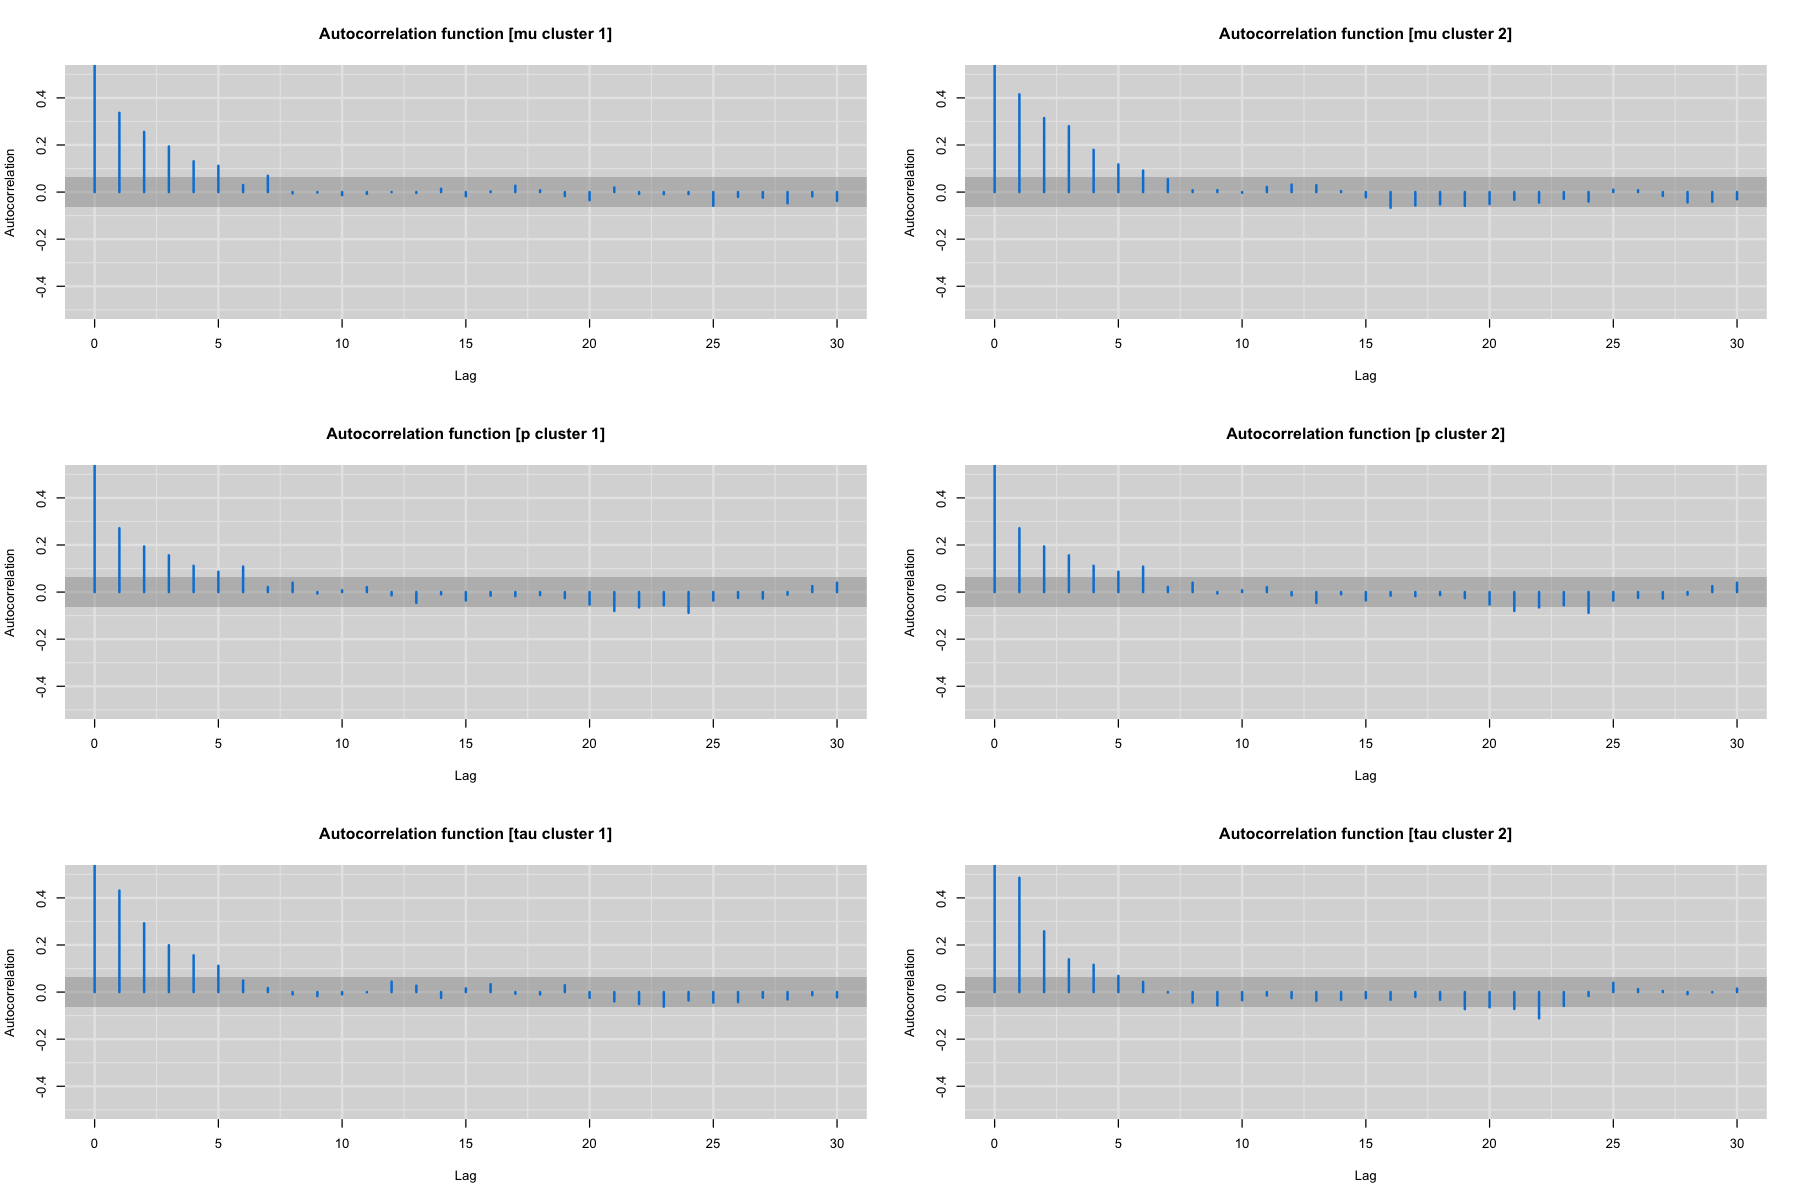

In [35]:
par(mfrow=c(3,2))
autplot1(coda_chain_dnormNA[,1],  ylim=c(-0.5,0.5), style='gray', main='Autocorrelation function [mu cluster 1]')
autplot1(coda_chain_dnormNA[,2],  ylim=c(-0.5,0.5), style='gray', main='Autocorrelation function [mu cluster 2]')
autplot1(coda_chain_dnormNA[,3],  ylim=c(-0.5,0.5), style='gray', main='Autocorrelation function [p cluster 1]')
autplot1(coda_chain_dnormNA[,4],  ylim=c(-0.5,0.5), style='gray', main='Autocorrelation function [p cluster 2]')
autplot1(coda_chain_dnormNA[,5],  ylim=c(-0.5,0.5), style='gray', main='Autocorrelation function [tau cluster 1]')
autplot1(coda_chain_dnormNA[,6],  ylim=c(-0.5,0.5), style='gray', main='Autocorrelation function [tau cluster 2]')

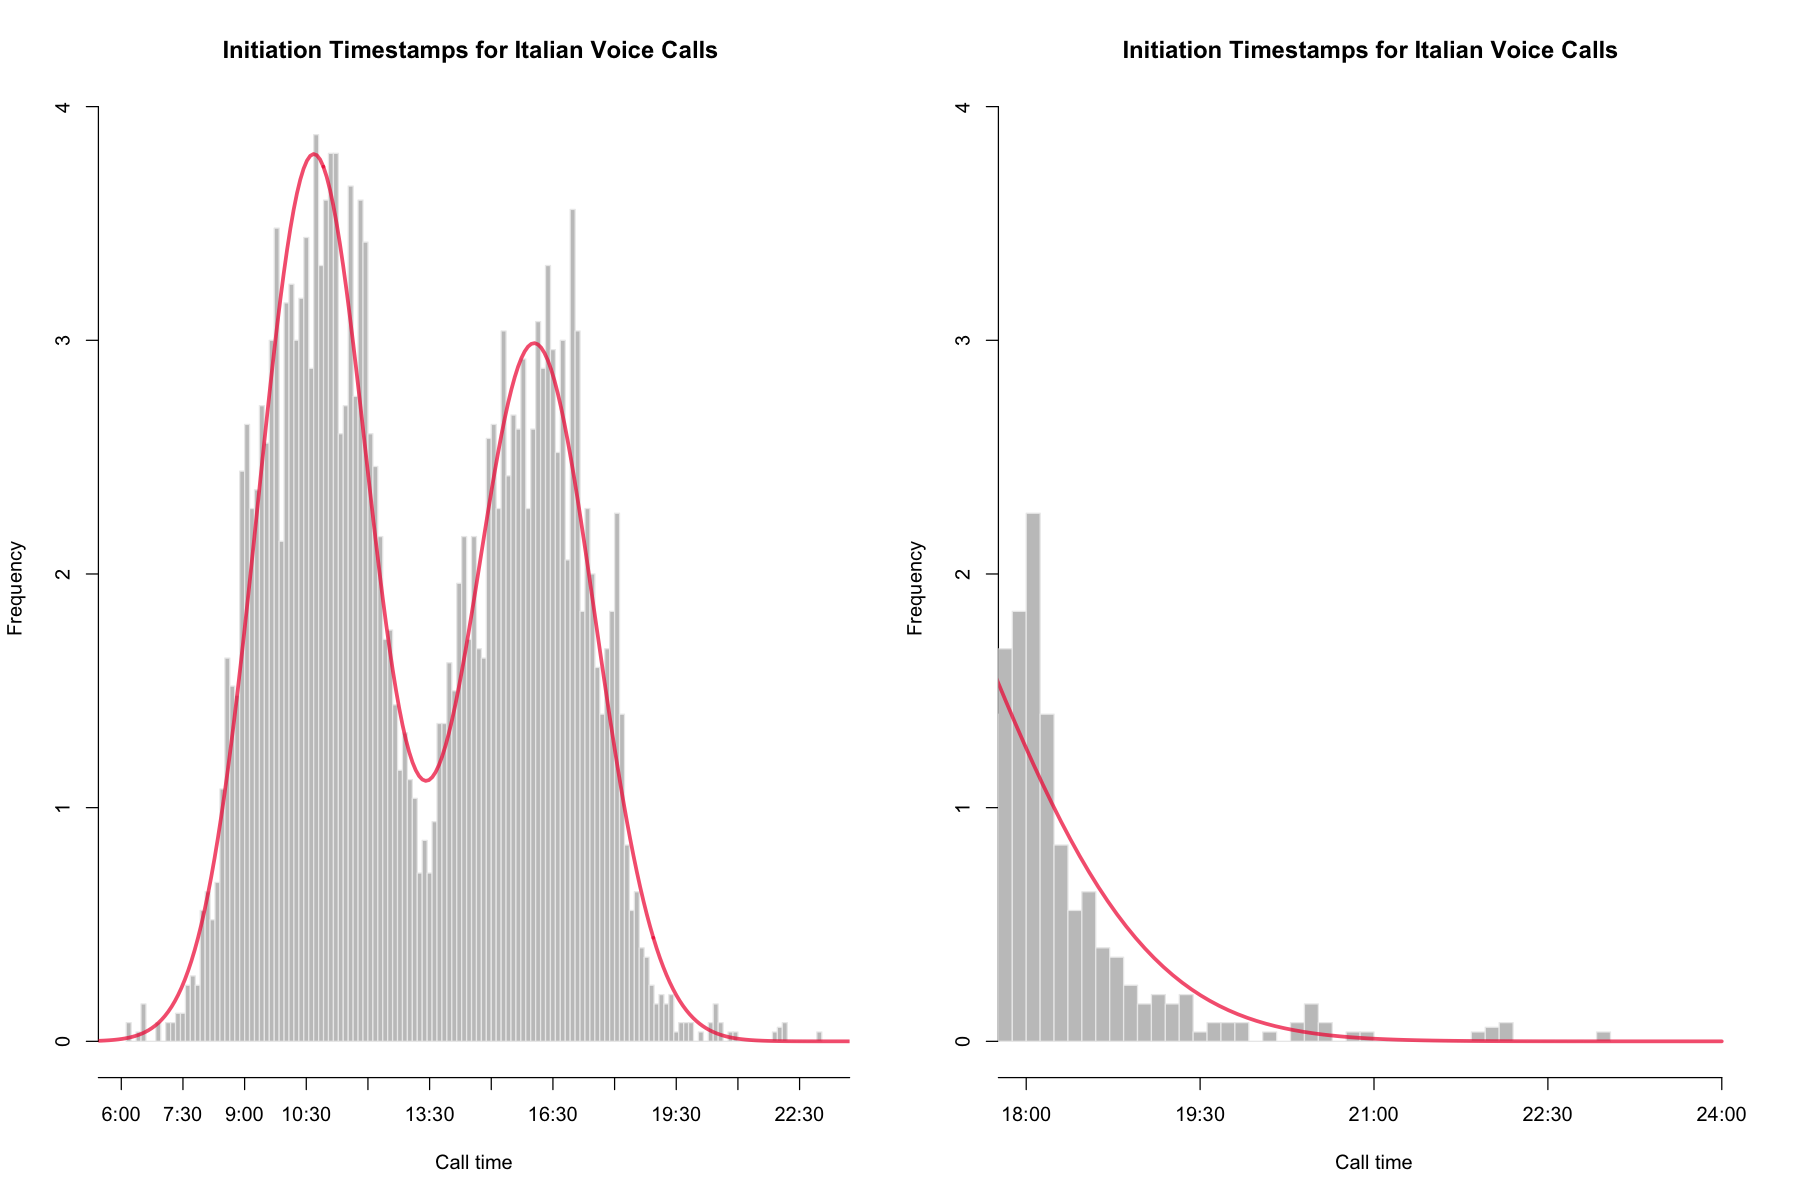

In [36]:
#thinning 
chain_dnormNA=as.data.frame(as.mcmc(read.csv('chain_dnormNA.csv')))
thinSel = seq(from=1, to=1000, by=5)
chain_dnormNA_thin = chain_dnormNA[thinSel,]
mean_norm_NA=lapply(chain_dnormNA_thin,mean)

par(mfrow = c(1,2))
hist(v_Minutes_Hashed_IT_NA[v_Minutes_Hashed_IT_NA>0.2][1:10000], nc = 130, main = 'Initiation Timestamps for Italian Voice Calls ', xlab = "Call time", 
       ylab = 'Frequency', col = rgb(0.75,0.75,0.75,alpha=0.9), border = rgb(0.92,0.92,0.92,alpha=1), freq = FALSE, xaxt = "n")

axis(side=1, at=seq(0,1,1/16), labels=paste0(trunc(seq(0,24,1.5)),c(rep(c(":00",":30"),8),":00")))

p = seq(0, 1, length = 300)
lines(p, mean_norm_NA[[3]]*dnorm(p, mean_norm_NA[[1]], 1/sqrt(mean_norm_NA[[5]]))+ mean_norm_NA[[4]]*dnorm(p, mean_norm_NA[[2]], 1/sqrt(mean_norm_NA[[6]])), lwd = 3, col = rgb(0.94,0.14,0.24, alpha = 0.7))


hist(v_Minutes_Hashed_IT_NA[v_Minutes_Hashed_IT_NA>0.2][1:10000], nc = 150, main = 'Initiation Timestamps for Italian Voice Calls ', xlab = "Call time", 
       ylab = 'Frequency', col = rgb(0.75,0.75,0.75,alpha=0.9), border = rgb(0.92,0.92,0.92,alpha=1), freq = FALSE, xlim = c(18/24, 1), xaxt = "n")

axis(side=1, at=seq(0,1,1/16), labels=paste0(trunc(seq(0,24,1.5)),c(rep(c(":00",":30"),8),":00")))

lines(p, mean_norm_NA[[3]]*dnorm(p, mean_norm_NA[[1]], 1/sqrt(mean_norm_NA[[5]]))+ mean_norm_NA[[4]]*dnorm(p, mean_norm_NA[[2]], 1/sqrt(mean_norm_NA[[6]])), lwd = 3, col = rgb(0.94,0.14,0.24, alpha=0.7))

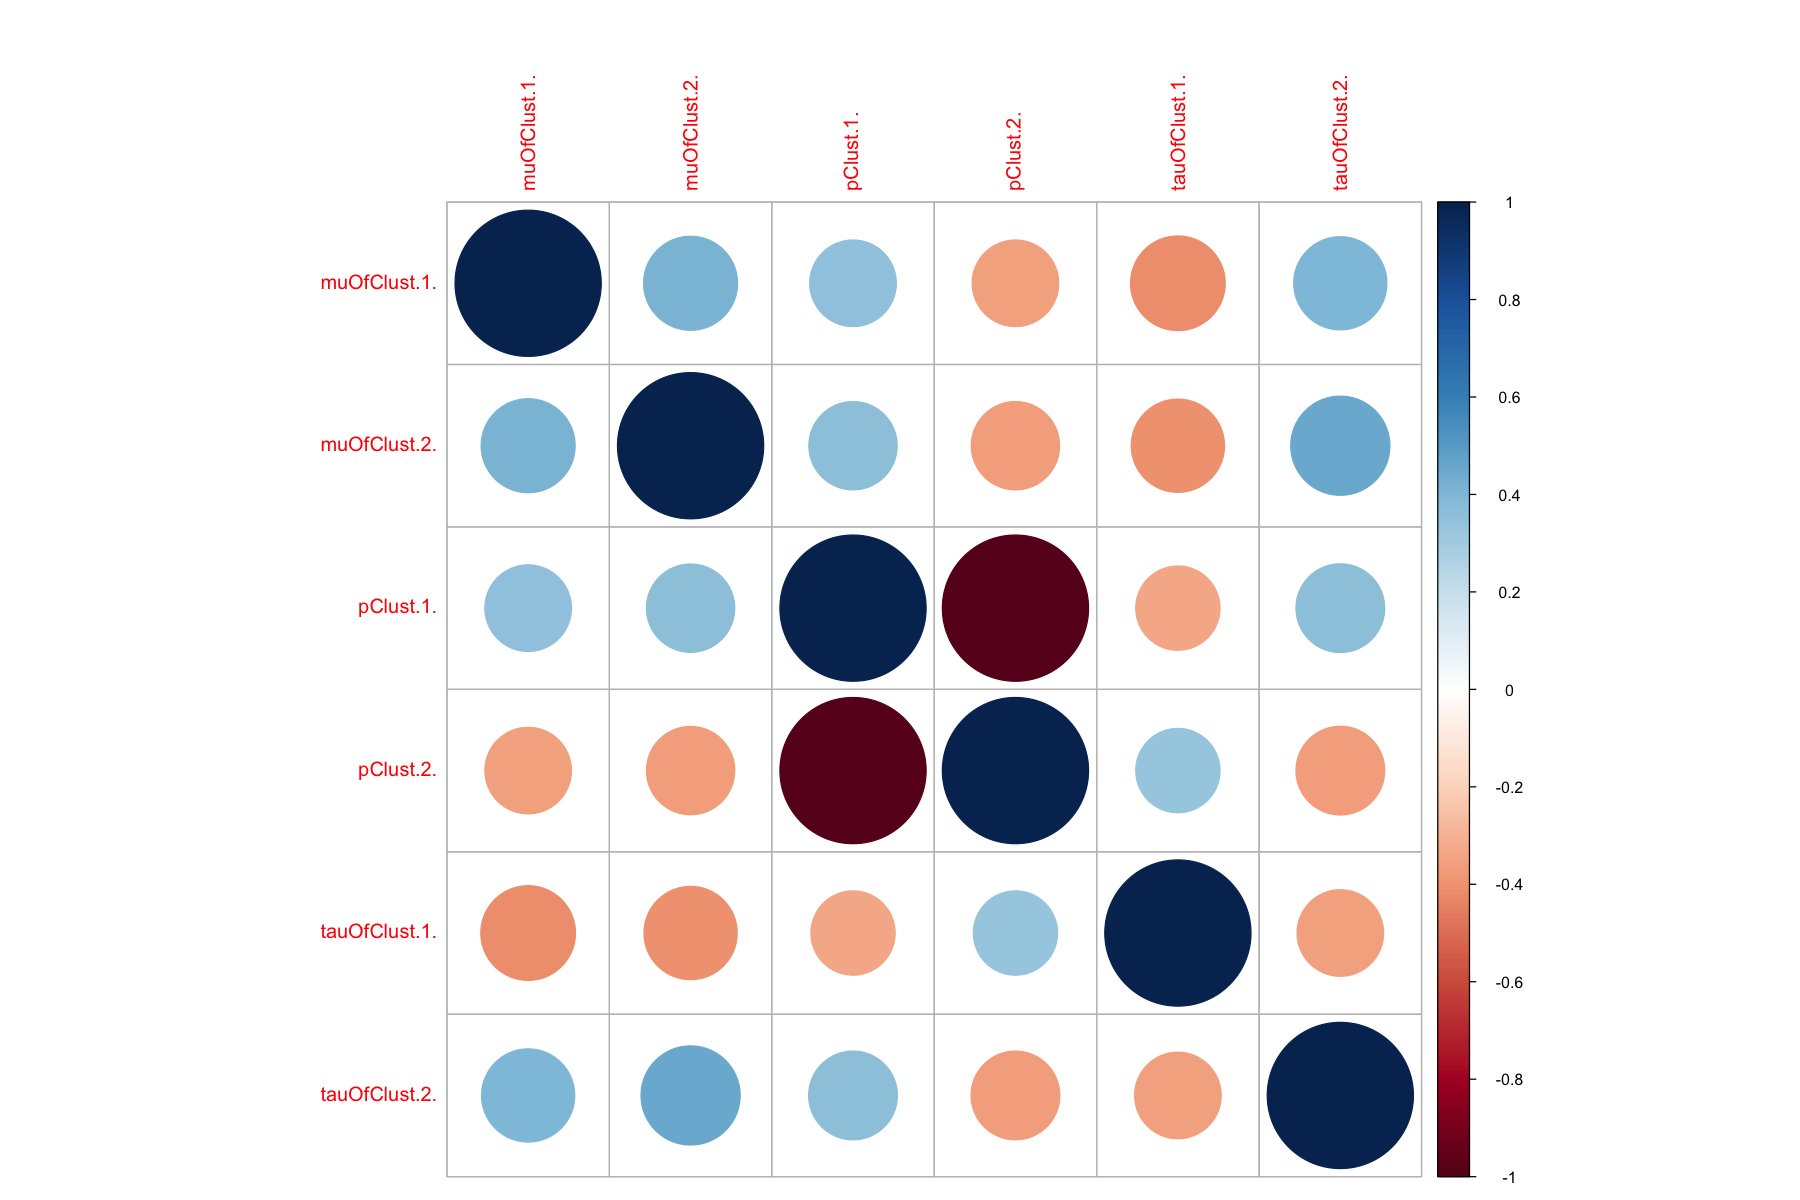

In [37]:
corrplot(crosscorr(as.mcmc(chain_dnormNA)))

### C. Other models as the sum of two distributions
We can now consider the call time distribution for the **ANSWERED CALLS** and try to describe it using a couple of distributions, that can be either two **beta** or two **gaussians**. The MCMC sampling is done again using JAGS.


For timing reasons, only **1000/10000 input data have been considered**. If one tries to consider the whole dataset, the simulation in many hours is not able to define the model, given the too high number of nodes that it would require.


In [38]:
df_2fit <- read.table("dati2Gaussiane.csv" , sep = ',', header = TRUE)
df_2fit 

mean_norm = df_2fit[,1]
mean_beta = df_2fit[,4]

norm,norm_n,beta_n,beta
<dbl>,<chr>,<chr>,<dbl>
0.4476281,muOfClust[1],alphaOfClust[1],35.8778437
0.6587247,muOfClust[2],alphaOfClust[2],59.3239023
0.5699314,pClust[1],betaOfClust[1],44.2688756
0.4300686,pClust[2],betaOfClust[2],30.7536480
330.9187805,tauOfClust[1],pClust[1],0.5695451
401.2536821,tauOfClust[2],pClust[2],0.4304549


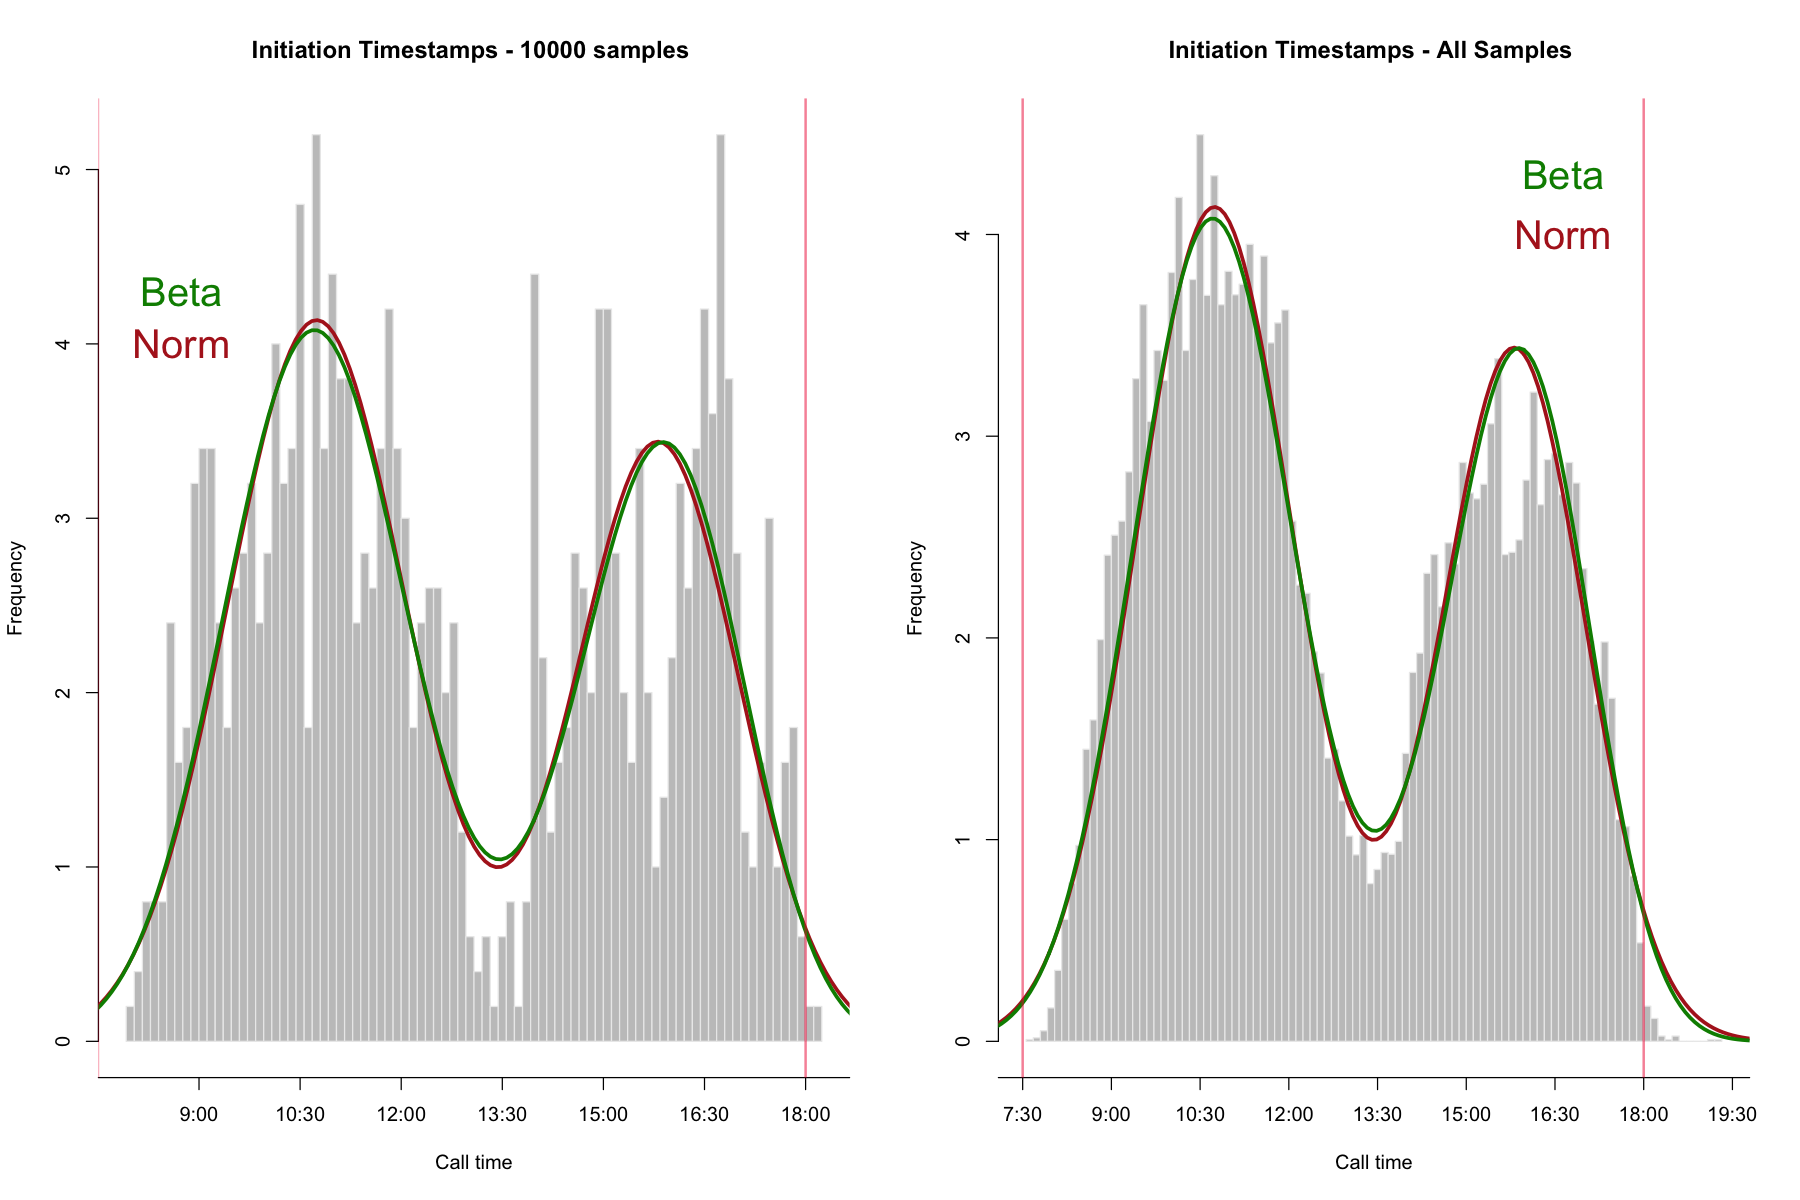

In [39]:
par(mfrow = c(1,2))

hist(v_Minutes_Hashed_IT[1:1000], nc = 130, main = 'Initiation Timestamps - 10000 samples ', xlab = "Call time", 
    ylab = 'Frequency', col = rgb(0.75,0.75,0.75,alpha=0.9), border = rgb(0.92,0.92,0.92,alpha=1), freq = FALSE, xaxt="n")

axis(side=1, at=seq(0,1,1/16), labels=paste0(trunc(seq(0,24,1.5)),c(rep(c(":00",":30"),8),":00")))

p = seq(0, 1, length = 300)
lines(p, mean_norm[[3]]*dnorm(p, mean_norm[[1]], 1/sqrt(mean_norm[[5]]))+ mean_norm[[4]]*dnorm(p, mean_norm[[2]], 1/sqrt(mean_norm[[6]])), lwd = 3, col = 'firebrick')

lines(p, mean_beta[[5]]*dbeta(p, mean_beta[[1]], mean_beta[[3]])+ mean_beta[[6]]*dbeta(p, mean_beta[[2]], mean_beta[[4]]), lwd = 3, col = 'green4')


abline(v = 7.5/24, col = rgb(0.94,0.14,0.24,alpha=0.5), lwd = 2)

abline(v = 18/(24), col = rgb(0.94,0.14,0.24,alpha=0.5), lwd = 2)


text(8.5/24+0.01,4.3, "Beta", cex =2, col = 'green4')
text(8.5/24+0.01,4, "Norm", cex =2, col = 'firebrick')


hist(v_Minutes_Hashed_IT, nc = 130, main = 'Initiation Timestamps - All Samples ', xlab ="Call time", 
    ylab = 'Frequency', col = rgb(0.75,0.75,0.75,alpha=0.9), border = rgb(0.92,0.92,0.92,alpha=1), freq = FALSE, xaxt = "n")

axis(side=1, at=seq(0,1,1/16), labels=paste0(trunc(seq(0,24,1.5)),c(rep(c(":00",":30"),8),":00")))

p = seq(0, 1, length = 300)
lines(p, mean_norm[[3]]*dnorm(p, mean_norm[[1]], 1/sqrt(mean_norm[[5]]))+ mean_norm[[4]]*dnorm(p, mean_norm[[2]], 1/sqrt(mean_norm[[6]])), lwd = 3, col = 'firebrick')

lines(p, mean_beta[[5]]*dbeta(p, mean_beta[[1]], mean_beta[[3]])+ mean_beta[[6]]*dbeta(p, mean_beta[[2]], mean_beta[[4]]), lwd = 3, col = 'green4')


abline(v = 7.5/24, col = rgb(0.94,0.14,0.24,alpha=0.5), lwd = 2)

abline(v = 18/(24), col = rgb(0.94,0.14,0.24,alpha=0.5), lwd = 2)


text(16.4/24+0.01,4.3, "Beta", cex =2, col = 'green4')
text(16.4/24+0.01,4, "Norm", cex =2, col = 'firebrick')

### D. Model as the sum of more distributions

Our observations on the datasets shows the presence of an **hole at around 17:00**, and so we can try to model our dataset using three distributions, instead of two and see if a better result can be obtain.


The job is done with JAGS using gaussians and betas with **9 free parameters**.

In [40]:
df_3fit <- read.table("dati3Gaussiane.csv" , row.names = 1, sep = ',', header = TRUE)
df_3fit

mean_norm = df_3fit[,1]
mean_beta = df_3fit[,4]

,norm,norm_n,beta_n,beta
,<dbl>,<chr>,<chr>,<dbl>
1,0.6338391,muOfClust[1],alphaOfClust[1],42.1980622
2,0.4465762,muOfClust[2],alphaOfClust[2],49.0119339
3,0.7024403,muOfClust[3],alphaOfClust[3],65.0099742
4,0.2888930,pClust[1],betaOfClust[1],46.4919170
5,0.5769479,pClust[2],betaOfClust[2],64.7312230
6,0.1341591,pClust[3],betaOfClust[3],33.8433429
7,557.5064534,tauOfClust[1],pClust[1],0.2383420
8,381.0171346,tauOfClust[2],pClust[2],0.3492746
9,1807.3719427,tauOfClust[3],pClust[3],0.4123833


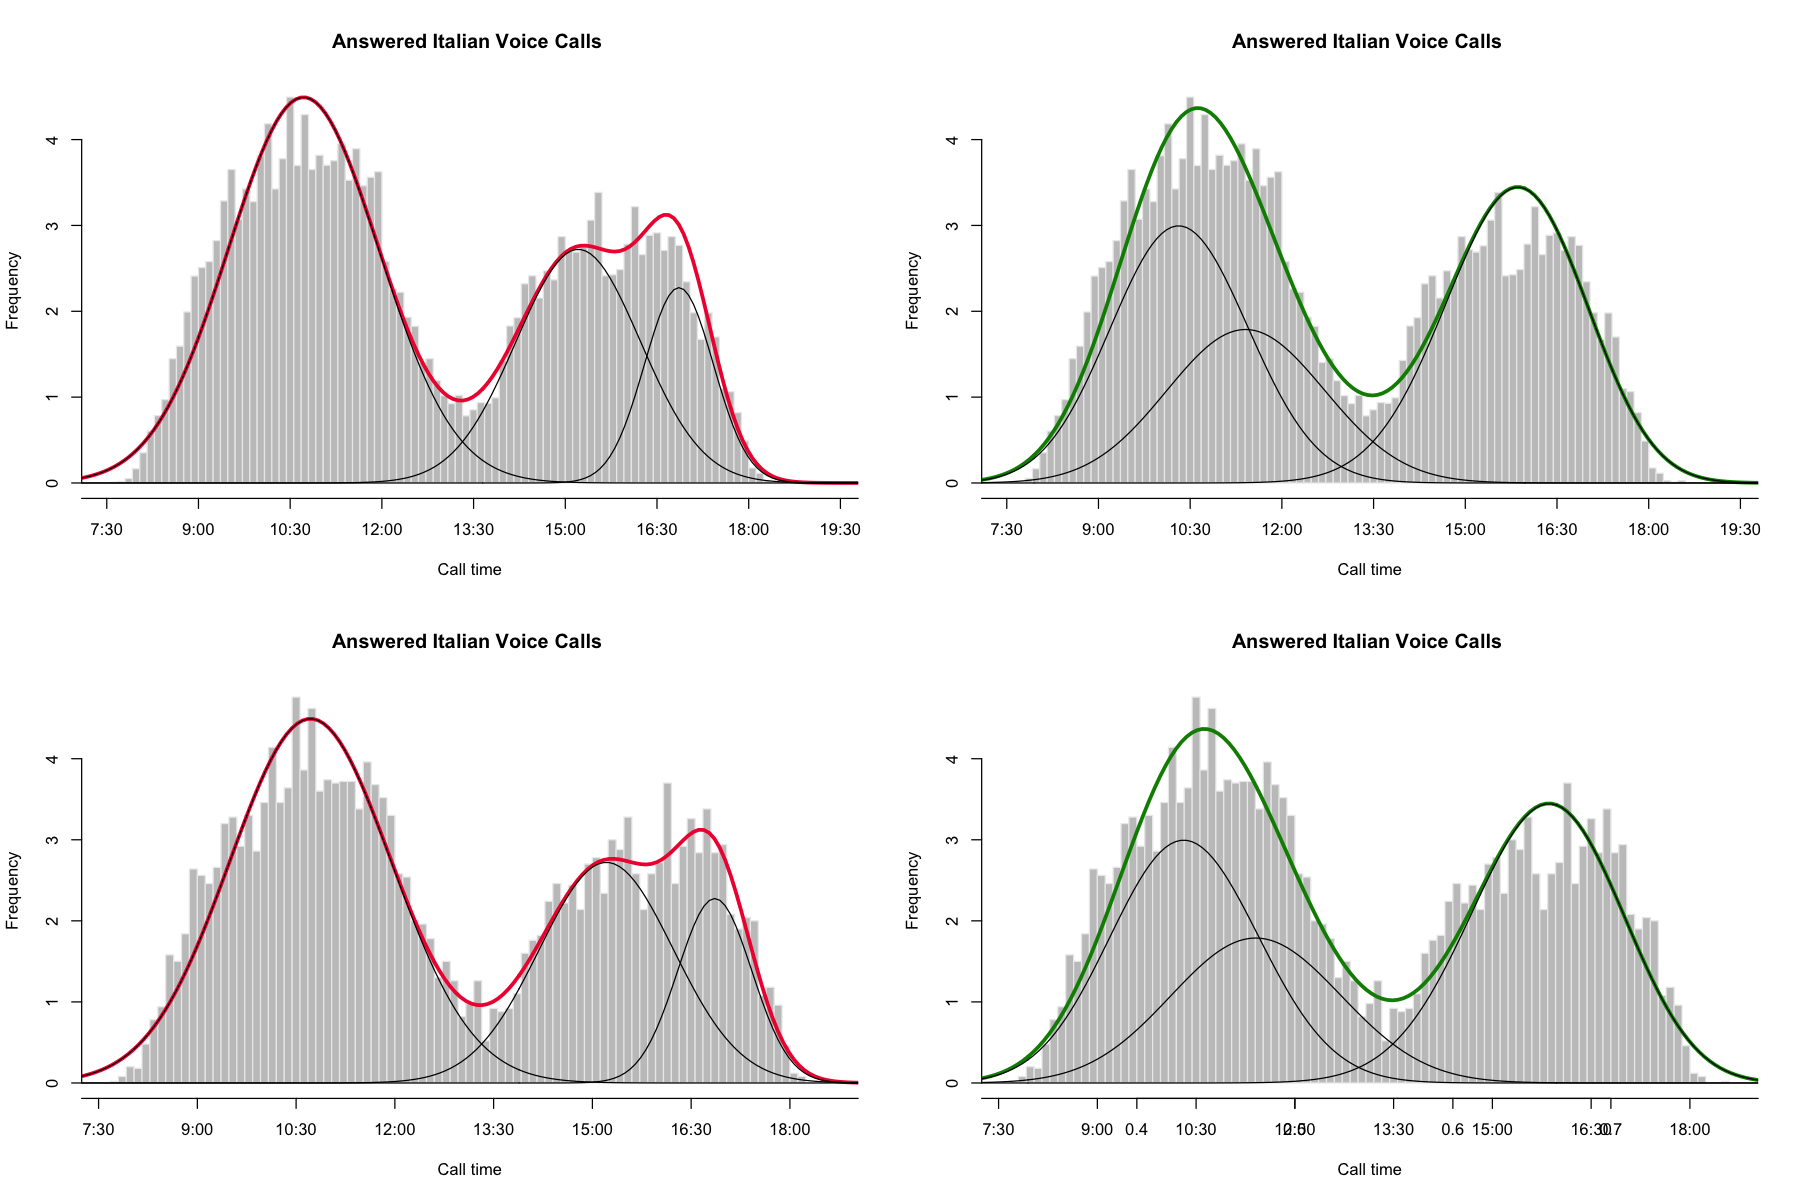

In [41]:
par(mfrow = c(2,2))


hist(v_Minutes_Hashed_IT, nc = 130, main = 'Answered Italian Voice Calls ', xlab = "Call time", 
    ylab = 'Frequency', col = rgb(0.75,0.75,0.75,alpha=0.9), border = rgb(0.92,0.92,0.92,alpha=1), freq = FALSE, xaxt="n")

axis(side=1, at=seq(0,1,1/16), labels=paste0(trunc(seq(0,24,1.5)),c(rep(c(":00",":30"),8),":00")))

p = seq(0, 1, length = 300)
lines(p, mean_norm[[4]]*dnorm(p, mean_norm[[1]], 1/sqrt(mean_norm[[7]]))+ mean_norm[[5]]*dnorm(p, mean_norm[[2]], 1/sqrt(mean_norm[[8]]))+ mean_norm[[6]]*dnorm(p, mean_norm[[3]], 1/sqrt(mean_norm[[9]])), lwd = 3, col =rgb(0.94,0.14,0.24,alpha=1))
lines(p, mean_norm[[4]]*dnorm(p, mean_norm[[1]], 1/sqrt(mean_norm[[7]])))

lines(p, mean_norm[[5]]*dnorm(p, mean_norm[[2]], 1/sqrt(mean_norm[[8]])))
lines(p, mean_norm[[6]]*dnorm(p, mean_norm[[3]], 1/sqrt(mean_norm[[9]])))

# lines(p, mean_beta[[7]]*dbeta(p, mean_beta[[1]], mean_beta[[4]])+ mean_beta[[8]]*dbeta(p, mean_beta[[2]], mean_beta[[5]])+ mean_beta[[9]]*dbeta(p, mean_beta[[3]], mean_beta[[6]]), lwd = 3, col = 'green4')


hist(v_Minutes_Hashed_IT, nc = 130, main = 'Answered Italian Voice Calls ', xlab = "Call time", 
    ylab = 'Frequency', col = rgb(0.75,0.75,0.75,alpha=0.9), border = rgb(0.92,0.92,0.92,alpha=1), freq = FALSE, xaxt="n")

axis(side=1, at=seq(0,1,1/16), labels=paste0(trunc(seq(0,24,1.5)),c(rep(c(":00",":30"),8),":00")))

p = seq(0, 1, length = 300)
lines(p, mean_beta[[7]]*dbeta(p, mean_beta[[1]], mean_beta[[4]])+ mean_beta[[8]]*dbeta(p, mean_beta[[2]], mean_beta[[5]])+ mean_beta[[9]]*dbeta(p, mean_beta[[3]], mean_beta[[6]]), lwd = 3, col = 'green4')
lines(p, mean_beta[[7]]*dbeta(p, mean_beta[[1]], mean_beta[[4]]))

lines(p, mean_beta[[8]]*dbeta(p, mean_beta[[2]], mean_beta[[5]]))
lines(p, mean_beta[[9]]*dbeta(p, mean_beta[[3]], mean_beta[[6]]))

# lines(p, mean_beta[[7]]*dbeta(p, mean_beta[[1]], mean_beta[[4]])+ mean_beta[[8]]*dbeta(p, mean_beta[[2]], mean_beta[[5]])+ mean_beta[[9]]*dbeta(p, mean_beta[[3]], mean_beta[[6]]), lwd = 3, col = 'green4')

hist(v_Minutes_Hashed_IT[1:10000], nc = 130, main = 'Answered Italian Voice Calls ', xlab = "Call time", 
    ylab = 'Frequency', col = rgb(0.75,0.75,0.75,alpha=0.9), border = rgb(0.92,0.92,0.92,alpha=1), freq = FALSE, xaxt="n")

axis(side=1, at=seq(0,1,1/16), labels=paste0(trunc(seq(0,24,1.5)),c(rep(c(":00",":30"),8),":00")))

p = seq(0, 1, length = 300)
lines(p, mean_norm[[4]]*dnorm(p, mean_norm[[1]], 1/sqrt(mean_norm[[7]]))+ mean_norm[[5]]*dnorm(p, mean_norm[[2]], 1/sqrt(mean_norm[[8]]))+ mean_norm[[6]]*dnorm(p, mean_norm[[3]], 1/sqrt(mean_norm[[9]])), lwd = 3, col = rgb(0.94,0.14,0.24,alpha=1))
lines(p, mean_norm[[4]]*dnorm(p, mean_norm[[1]], 1/sqrt(mean_norm[[7]])))

lines(p, mean_norm[[5]]*dnorm(p, mean_norm[[2]], 1/sqrt(mean_norm[[8]])))
lines(p, mean_norm[[6]]*dnorm(p, mean_norm[[3]], 1/sqrt(mean_norm[[9]])))

# lines(p, mean_beta[[7]]*dbeta(p, mean_beta[[1]], mean_beta[[4]])+ mean_beta[[8]]*dbeta(p, mean_beta[[2]], mean_beta[[5]])+ mean_beta[[9]]*dbeta(p, mean_beta[[3]], mean_beta[[6]]), lwd = 3, col = 'green4')

hist(v_Minutes_Hashed_IT[1:10000], nc = 130, main = 'Answered Italian Voice Calls ', xlab = "Call time", 
    ylab = 'Frequency', col = rgb(0.75,0.75,0.75,alpha=0.9), border = rgb(0.92,0.92,0.92,alpha=1), freq = FALSE)

axis(side=1, at=seq(0,1,1/16), labels=paste0(trunc(seq(0,24,1.5)),c(rep(c(":00",":30"),8),":00")))

p = seq(0, 1, length = 300)
lines(p, mean_beta[[7]]*dbeta(p, mean_beta[[1]], mean_beta[[4]])+ mean_beta[[8]]*dbeta(p, mean_beta[[2]], mean_beta[[5]])+ mean_beta[[9]]*dbeta(p, mean_beta[[3]], mean_beta[[6]]), lwd = 3, col = 'green4')
lines(p, mean_beta[[7]]*dbeta(p, mean_beta[[1]], mean_beta[[4]]))
lines(p, mean_beta[[8]]*dbeta(p, mean_beta[[2]], mean_beta[[5]]))
lines(p, mean_beta[[9]]*dbeta(p, mean_beta[[3]], mean_beta[[6]]))

# lines(p, mean_beta[[7]]*dbeta(p, mean_beta[[1]], mean_beta[[4]])+ mean_beta[[8]]*dbeta(p, mean_beta[[2]], mean_beta[[5]])+ mean_beta[[9]]*dbeta(p, mean_beta[[3]], mean_beta[[6]]), lwd = 3, col = 'green4')

The result is pretty good, and seems to describe optimally the call time distribution.

## 5. Conclusions



* We have been able to carry out many of the things we proposed at the beginning of the work. 
* We described specific behaviours of some of the features, such as the distribution for the **call duration** or the **call time** during the day. 
* Using Bayesian Networks we captured some of the main dependences between variables
* Exploiting JAGS we were able to draw samples from the distributions of agent interaction time, number of calls per day, not-answered calls in outside-working hours, and from the distribution of answered and not answered calls through out the whole day. 

Being able to sample data from this distributions may allow UNOX to tackle more effectively calls not answered, 
and spread shift in a more confident way throughout the working days. Furthermore, Bayesian Network correlation may be used for addressing specific behaviour of operators, and tackle it effectively. While working on this dataset, other ideas popped out: we can for example seeks for correlations between the number of calls per day and the total turnover of the company or make a deeper analysis of the Covid impact on the call-center of UNOX.